In [27]:
%run NB_Image.ipynb

In [28]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [29]:
import matplotlib.pyplot as plt

params = {'legend.fontsize': '16',
          'figure.figsize': (15, 5),
         'axes.labelsize': '28',
         'axes.titlesize':'28',
         'xtick.labelsize':'28',
         'ytick.labelsize':'28'}

plt.rcParams.update(params)

In [30]:
from astropy.io import ascii

c = ascii.read("../data/mmsf2outcube_COSMOSC_allifu.cat")

In [31]:
# correct fluxes in catalog for galactic extintion
# here using Schlegel, Finkbeiner & Davis (1998) extinction maps and
# Cardelli, Clayton & Mathis (1989) extinction law.
from __future__ import print_function
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

import numpy as np
import extinction
from extinction import ccm89

from astropy.table import Table, Column
import astropy.units as u

R = 3.1

sfd = SFDQuery()

    
if not "flux_ext_corr" in c.colnames:
    c.add_column( Column([np.nan]*len(c), name="flux_ext_corr", dtype=float, description="Flux corrected for galactic extinction." ) )
if not "E(B-V)" in c.colnames:
    c.add_column( Column([np.nan]*len(c), name="E(B-V)", dtype=float, description="E(B_V) from Schlegel, Finkbeiner & Davis (1998) at object location." ) )
    
for r in c[:]:
    coords = SkyCoord(r['ra_com']*u.degree, r['dec_com']*u.degree, frame='icrs')
    ebv = sfd(coords)
    r["E(B-V)"] = ebv
    A_V = R * ebv
    r["flux_ext_corr"] = extinction.remove( extinction.ccm89( np.array([r["wl_com"]]), A_V, R), r["flux"])


# compute absolute Luminosities assuming central detection wavelength is Lyman Alpha
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u

def toL(f,z):
    DL = cosmo.luminosity_distance(z).to(u.cm) # luniosity distance in cm
    return 4.*np.pi*DL**2. * f * u.erg / u.second / (u.cm)**2.

if not "L(if LyA)" in c.colnames:
    c.add_column( Column([np.nan]*len(c), name="L(if LyA)", dtype=float, description="Absolute luminosity assuming is Lyman Alpha.", unit=u.erg/u.second) )

for r in c[:]:
    z = r["wl_com"]/1216. - 1.
    r["L(if LyA)"] = toL(f=r["flux_ext_corr"],z=z).value

    
# compute proper transverse distance scale (kpc per arcsec) assuming wl_com is LyA.
if not "proper_transv_distance" in c.colnames:
    c.add_column( Column([np.nan]*len(c), name="proper_transv_distance", dtype=float, description="Separation in transverse proper kpc corresponding to an arcsec.", unit=u.kpc/u.arcsec) )

for r in c[:]:
    z = r["wl_com"]/1216. - 1.
    r["proper_transv_distance"] = cosmo.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec).value

/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [32]:
field = "COSMOSC"

In [33]:
# compute proper transverse distance scale (kpc per arcsec) assuming wl_com is LyA.
if not "area" in c.colnames:
    c.add_column( Column([np.nan]*len(c), name="area", dtype=float, description="Projected area in  sq. arcsec.", unit=u.arcsec*u.arcsec) )

cache = {}
for r in c[:]:
    ifu = r["ifu"]
    id = r["id"]
    fn = "../data/mmap_{}_{}.fits.gz".format(field,ifu)
    if not fn in cache:
        cache[fn] = spectrum.readSpectrum(fn)
    s = cache[fn]
    
    m = np.sum( s.data == id , axis=0)
    pixel = np.sum(m >0)
    A = pixel * 0.5**2
        
    
    r["area"] = A

In [11]:
cosmo.kpc_proper_per_arcmin(5.76).to(u.kpc/u.arcsec)*50. /.7

<Quantity 427.66962987 kpc / arcsec>

In [12]:
ii = c["class2"] == "halo"
aa = (c["class2"] == "agn") * c["xray_counterpart"]
ff = (c["class2"] == "filament") 
pp = c["class2"] == "pointsource"
gg = (c["split_good"] == "True") 


In [13]:
sum(ff * gg)

47

/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


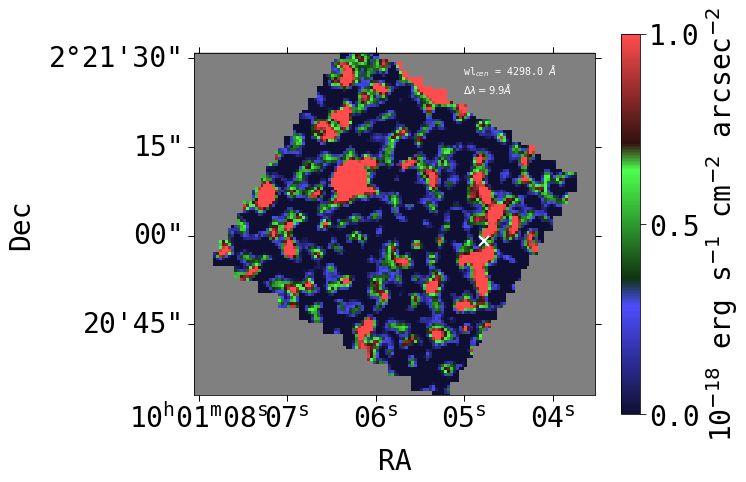

In [14]:
# Select prime example of filament for reference
field = "COSMOSC"
jj  =  c["ifu"] == '025' 
jj *=  c["id"] == 10018
r = c[jj][0]

field, ifu = "COSMOSC", "025"
wlstart = r["wl_com"] - 5.
wlend = r["wl_com"] + 5.
ra,dec = r["ra_com"], r["dec_com"]
vmin=0.
vmax=1.

fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
fncal = "../specphot/mean_cal_{}.txt".format(field)


show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, ra = ra, dec = dec)
plt.xlabel("RA")
plt.ylabel("Dec")


In [15]:
fncube

'../data/outcube_COSMOSC_025.fits.gz'

In [16]:
import numpy as np

fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
fnmap  = "../data/mmap_{}_{}.fits.gz".format(field, ifu)

c = spectrum.readSpectrum(fncube)
m = spectrum.readSpectrum(fnmap)

xx,yy,zz = np.arange(c.data.shape[2]), np.arange(c.data.shape[1]), np.arange(c.data.shape[0])
Z,Y,X = np.meshgrid(zz,yy,xx,indexing='ij')

In [17]:
jj =  m.data == 10018 
cfilter = np.zeros_like(c.data)
cfilter[jj] = c.data[jj]

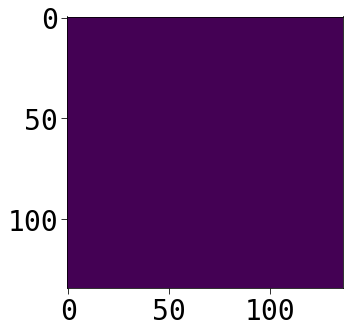

In [18]:
plt.imshow(cfilter[420])

<IPython.core.display.Javascript object>


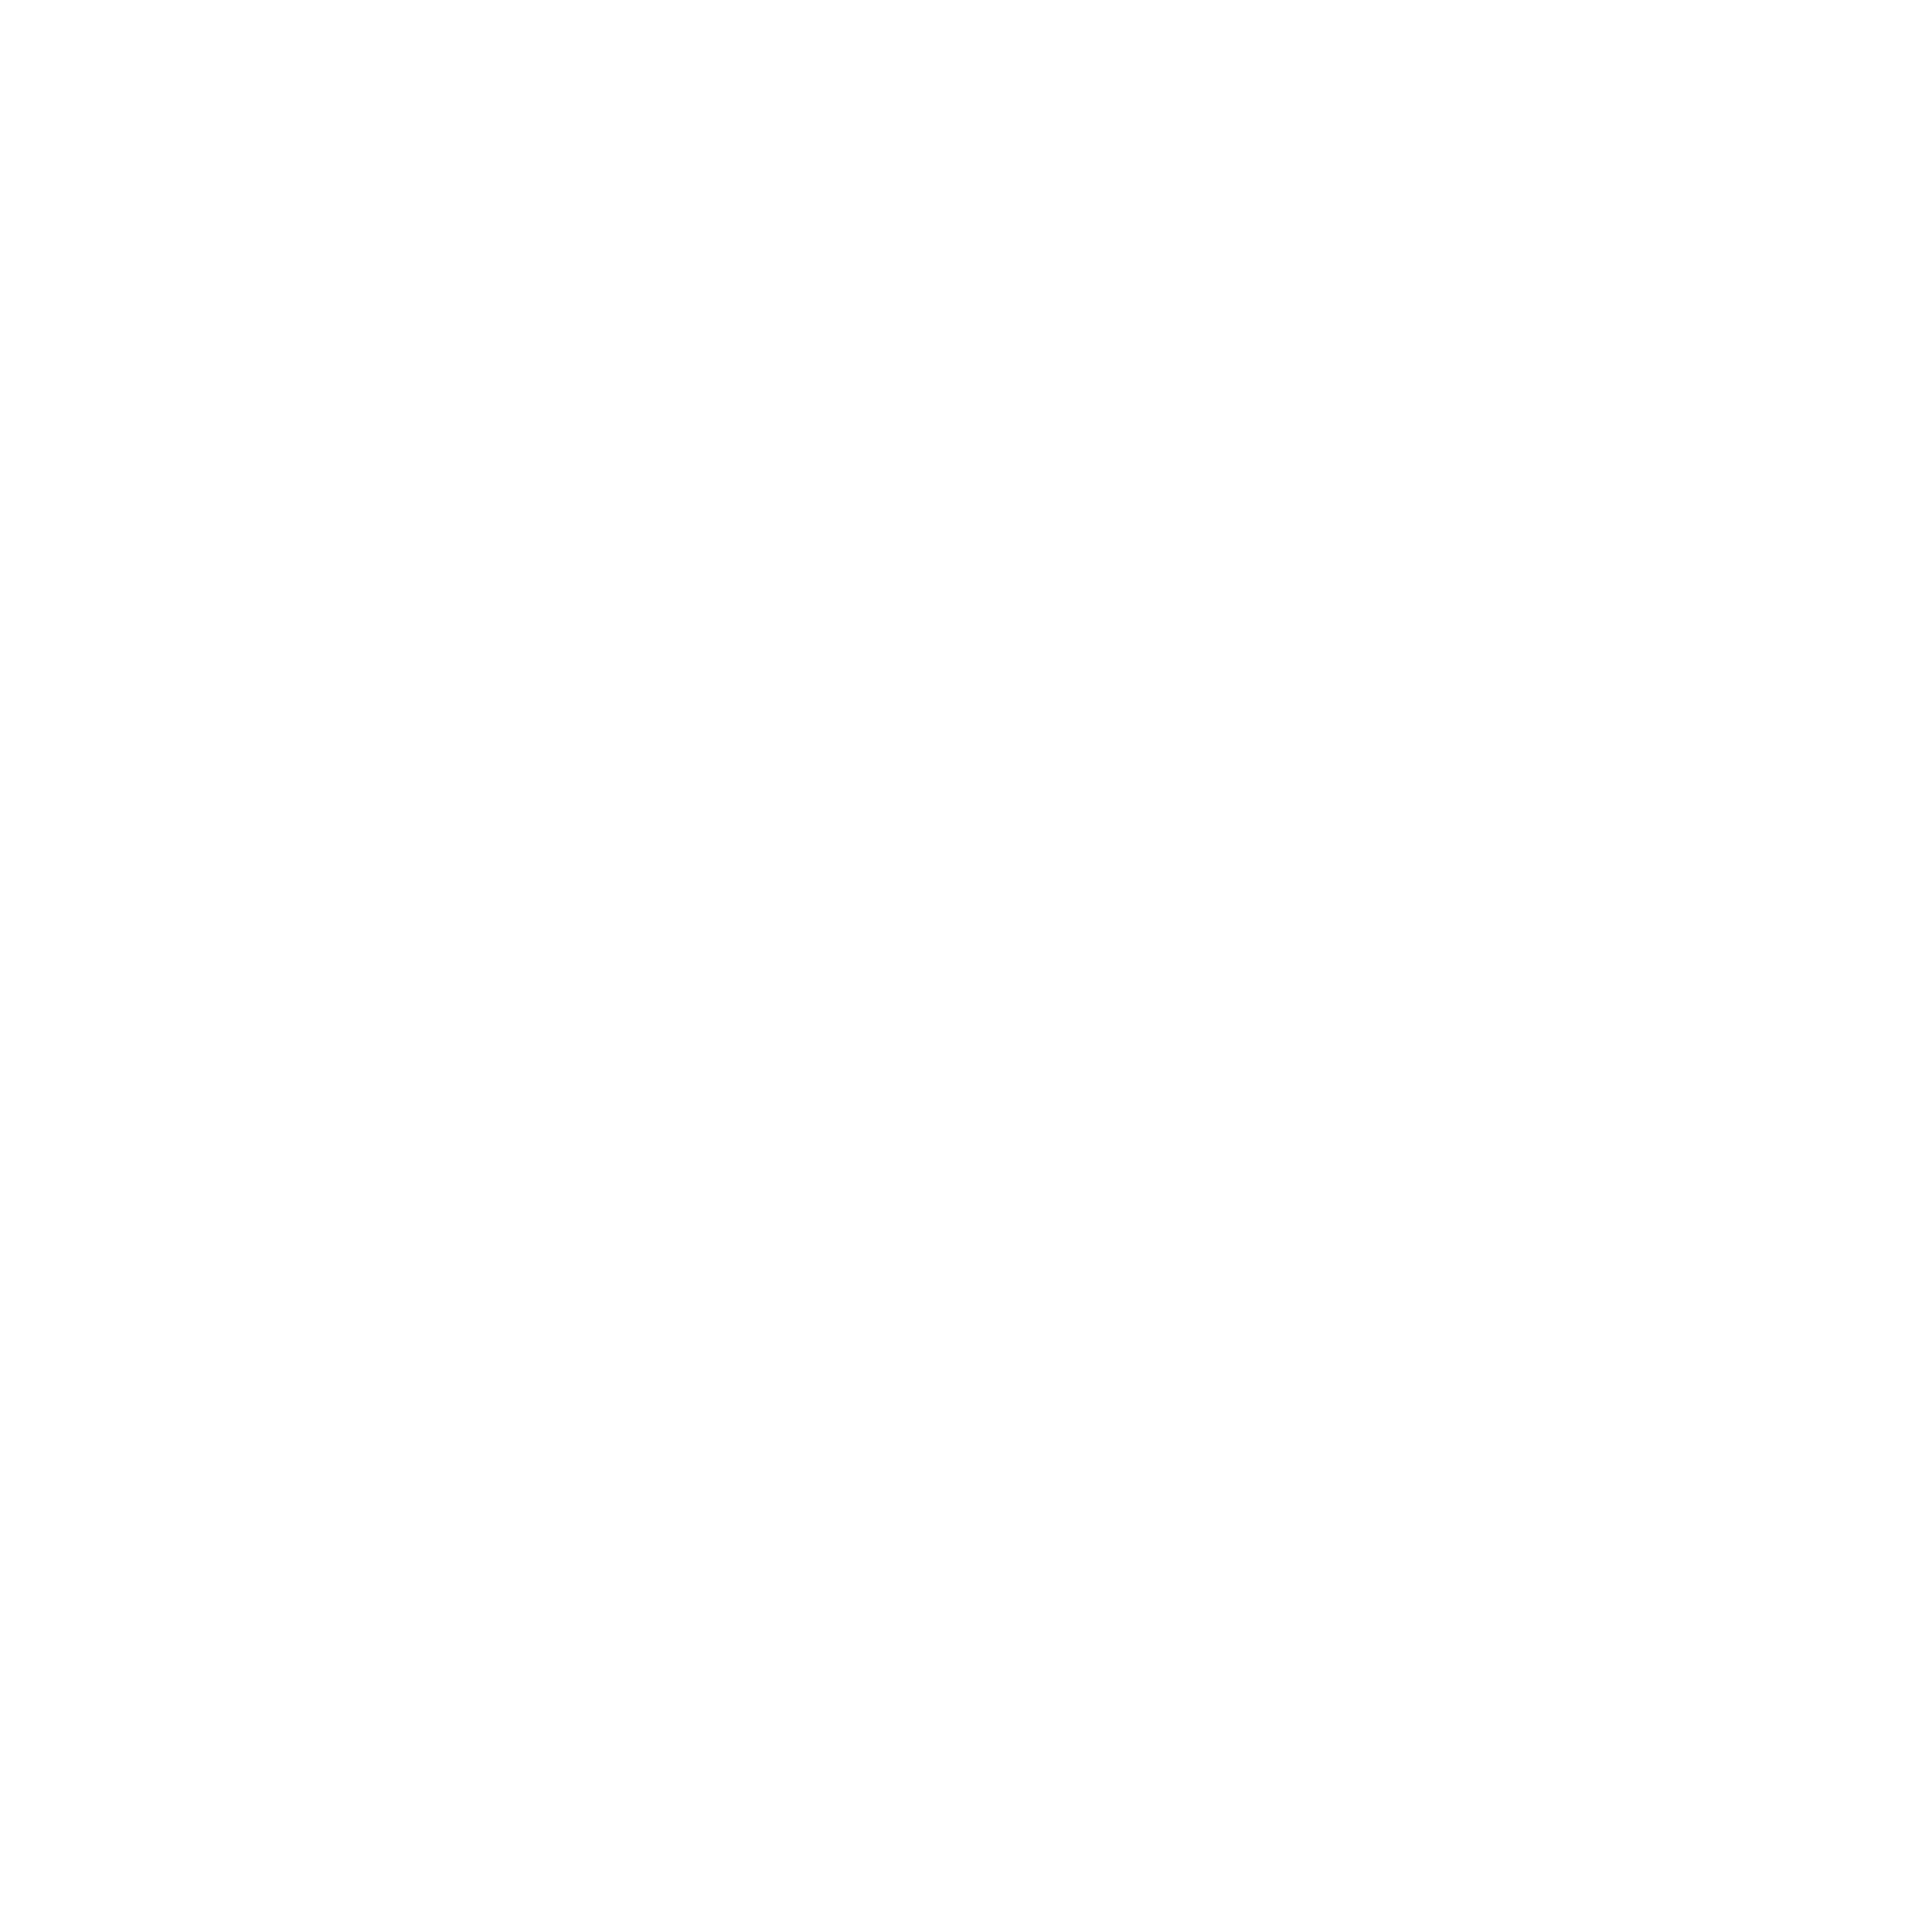

<IPython.core.display.Javascript object>


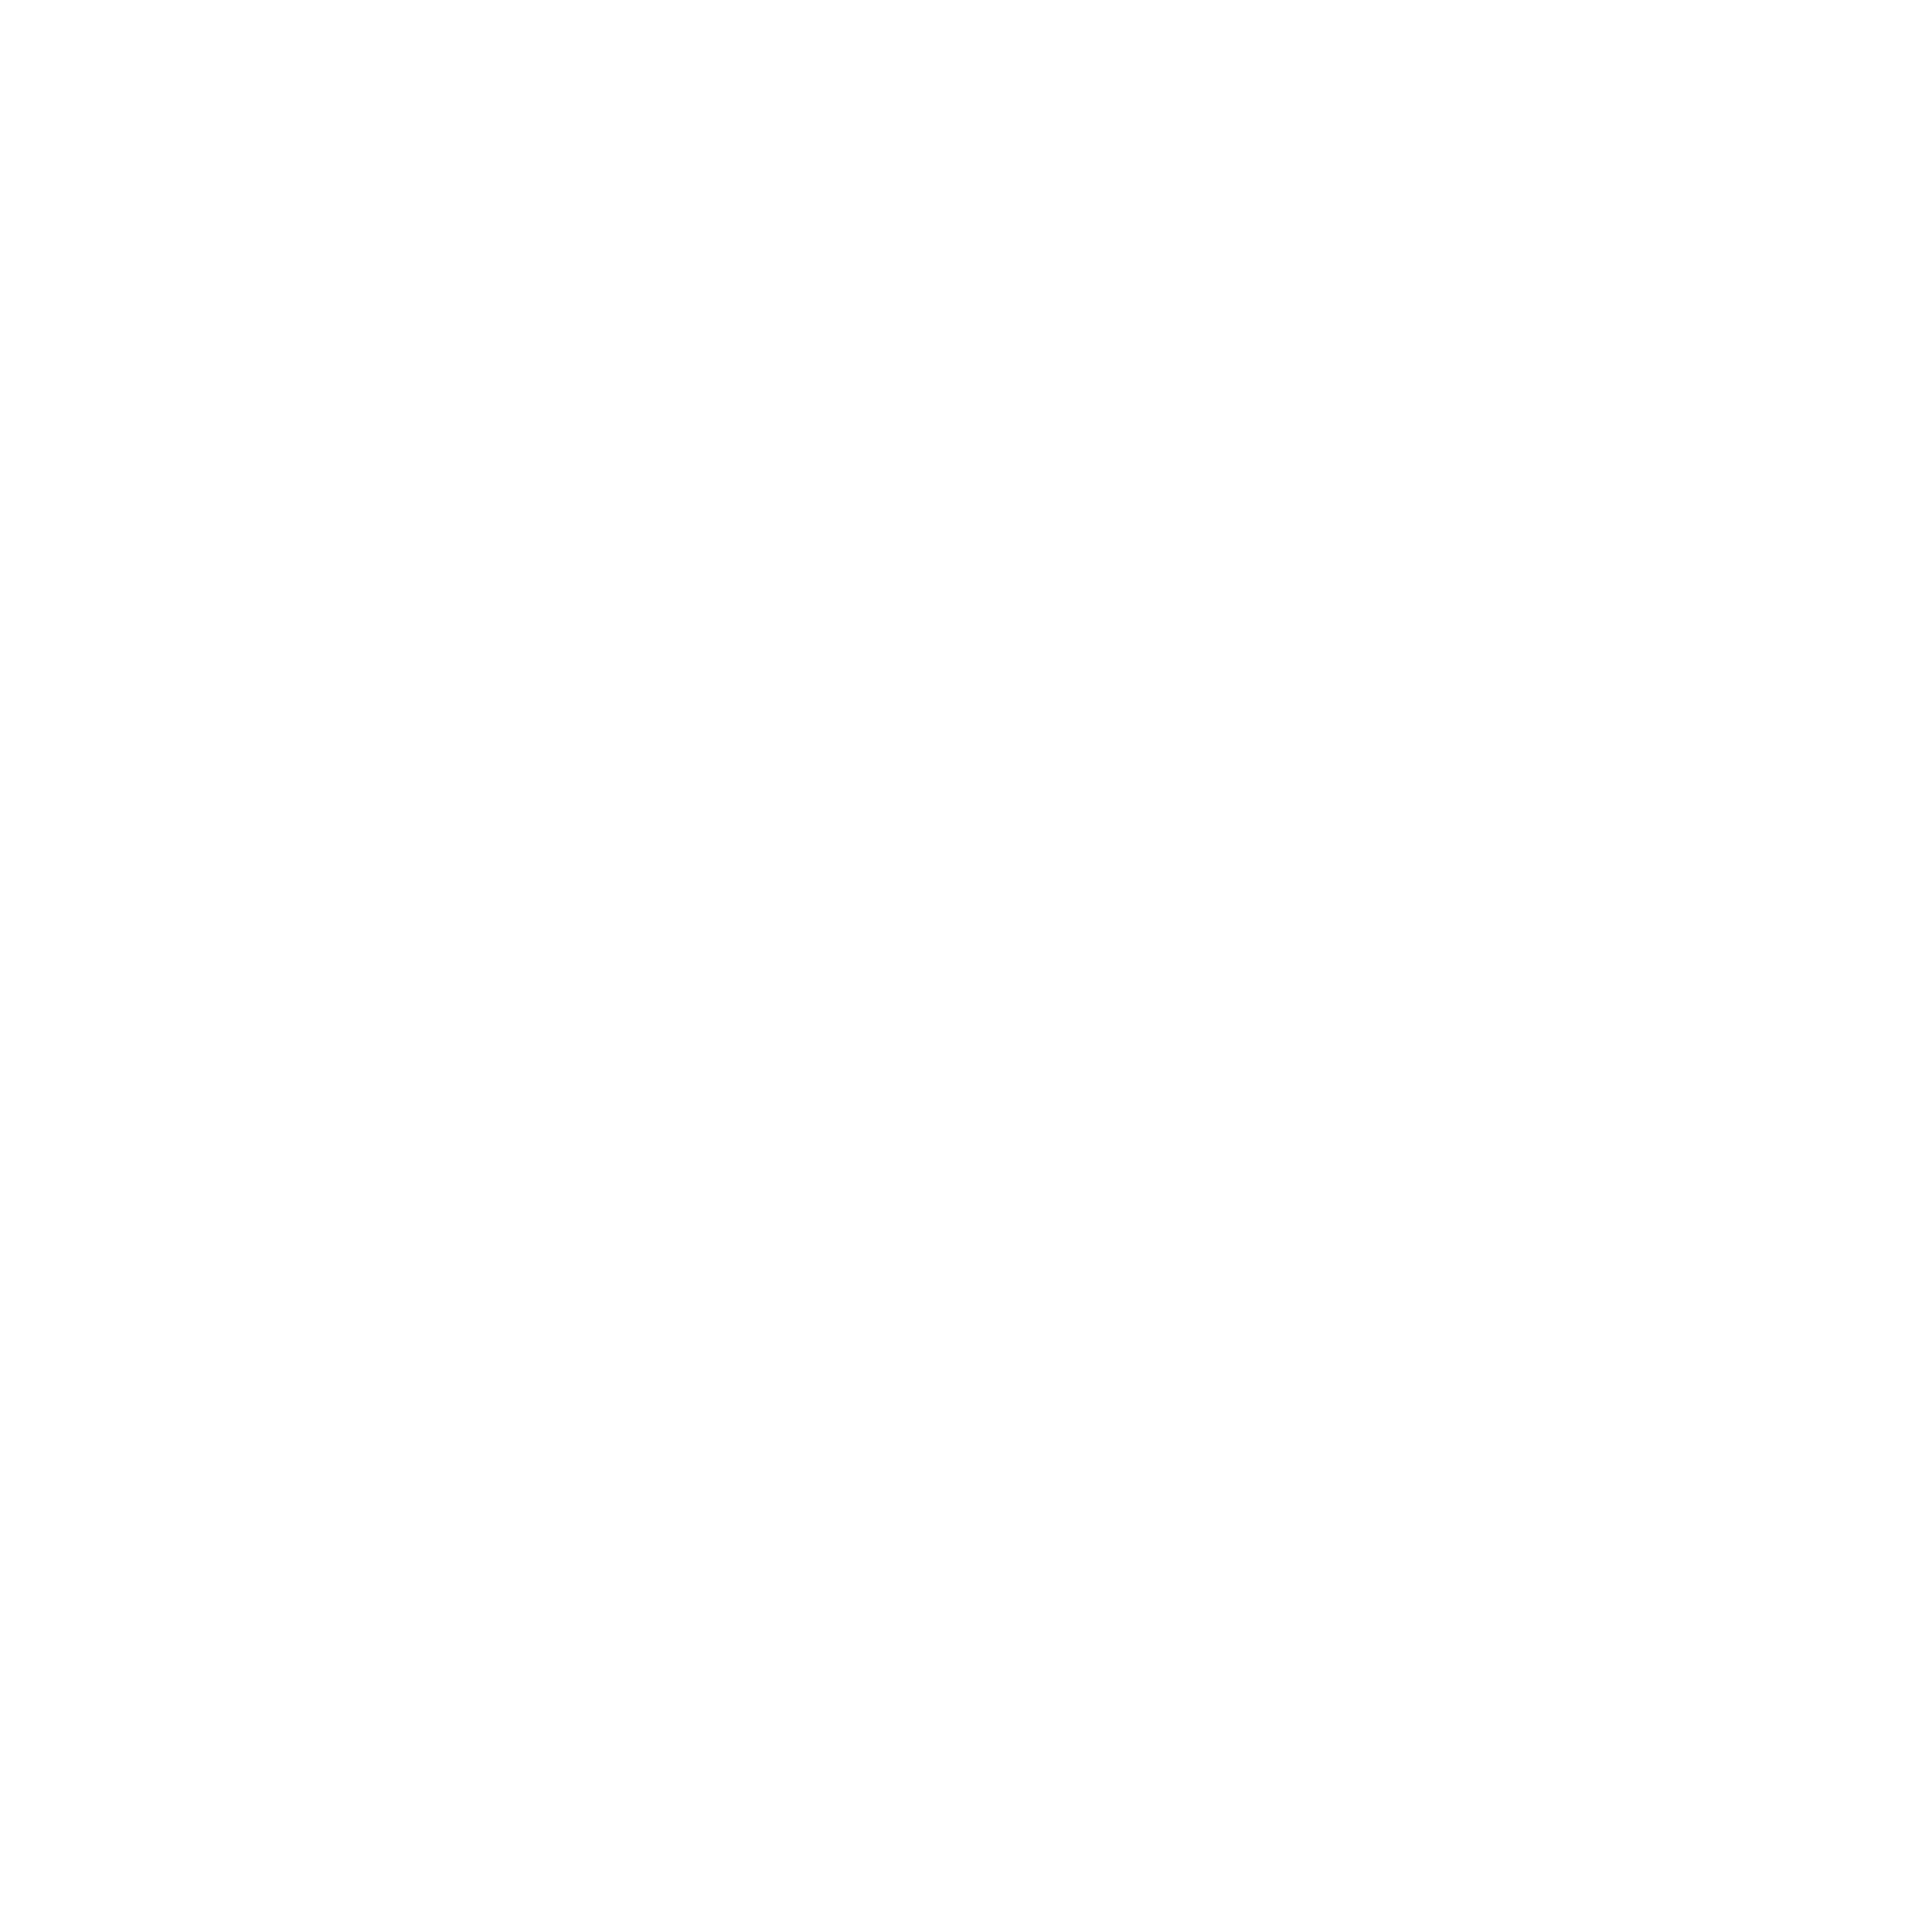

In [19]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt

%matplotlib notebook
ii =  m.data.flatten() == 10018 

#hdu = c.hdu
#w = WCS(hdu.header)
#w = w.dropaxis(2)
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(X.flatten()[ii], Y.flatten()[ii], Z.flatten()[ii], c.data.flatten()[ii], marker=m)
ax.scatter(X.flatten()[ii], Y.flatten()[ii], Z.flatten()[ii], alpha =.5,c=c.data.flatten()[ii], vmin=0., vmax=.6)
#ax.scatter([1],[1],[1])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [20]:
# size2d vs dwl
plt.plot((c["dwl"][pp]),2.5*c["size2d"][pp],'.', label="pointsources", alpha=.2)
plt.plot((c[ii]["dwl"]), 2.5*c[ii]["size2d"],'.', label="halos", alpha=1.)
plt.plot((c[ii*gg]["dwl"]), 2.5*c[ii*gg]["size2d"],'r.', label="good halos", alpha=1.)


#plt.plot((c[jj]["dwl"]), 2.5*c[jj]["size2d"],'ro', label="fil")
plt.xlabel("dwl")
plt.ylabel("size2d")
plt.xlim([0,150])
plt.ylim([0,40.])
plt.legend()

TypeError: 'Spectrum' object is not subscriptable

In [21]:
# size2d vs flux
plt.plot((c["flux"][pp]),2.5*c["size2d"][pp],'.', label="pointsources")
plt.plot((c[ii]["flux"]), 2.5*c[ii]["size2d"],'.', label="halos")
plt.plot((c[ii*gg]["flux"]), 2.5*c[ii*gg]["size2d"],'r.', label="split detected halos")
plt.xlabel("flux")
plt.ylabel("2.5 x size2d")
plt.ylim([0,40.])
plt.xlim([0,5e-16])
plt.legend()

TypeError: 'Spectrum' object is not subscriptable

<IPython.core.display.Javascript object>


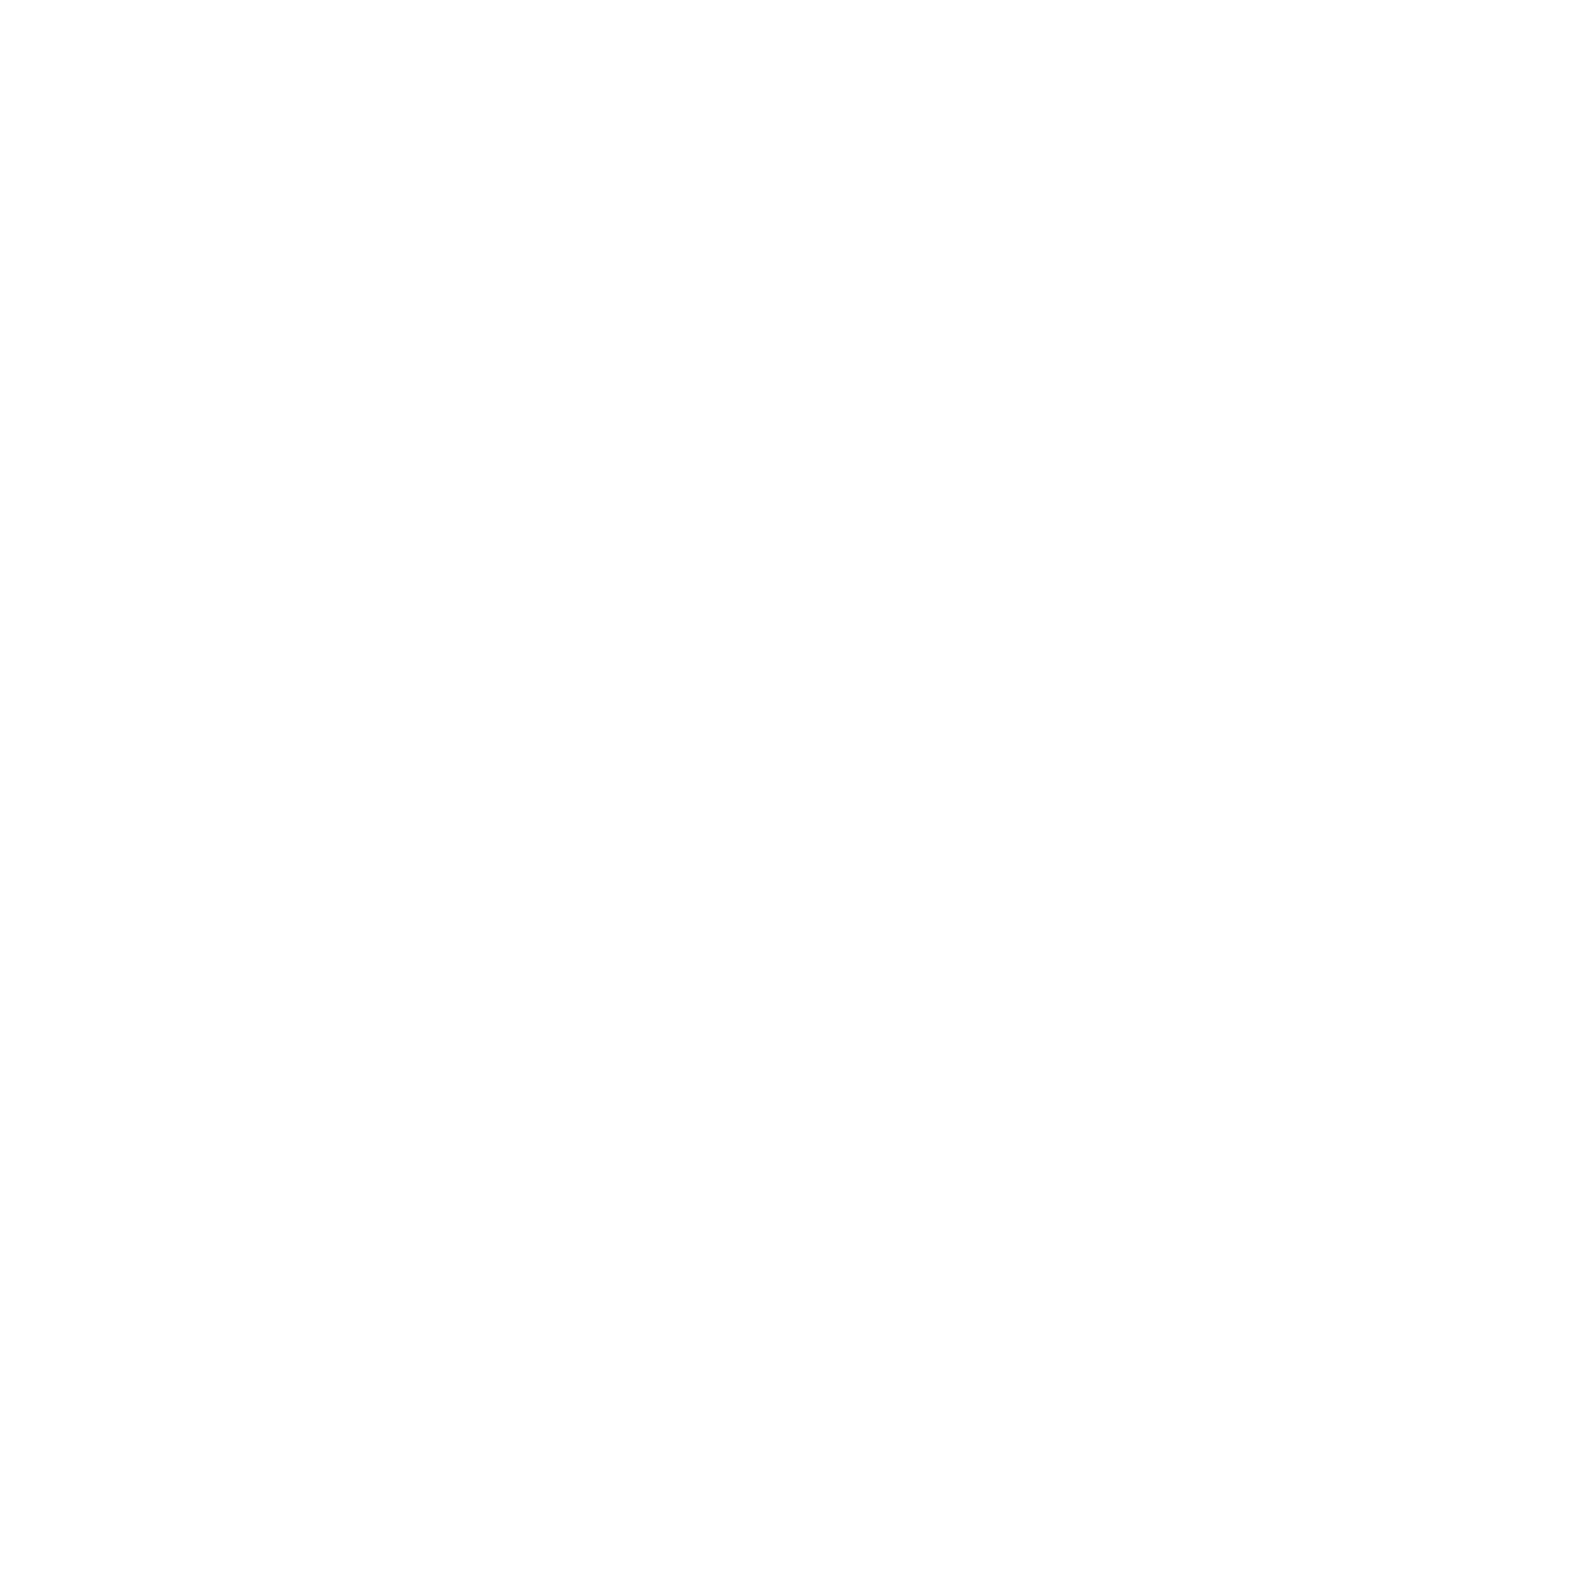

TypeError: 'Spectrum' object is not subscriptable

<IPython.core.display.Javascript object>


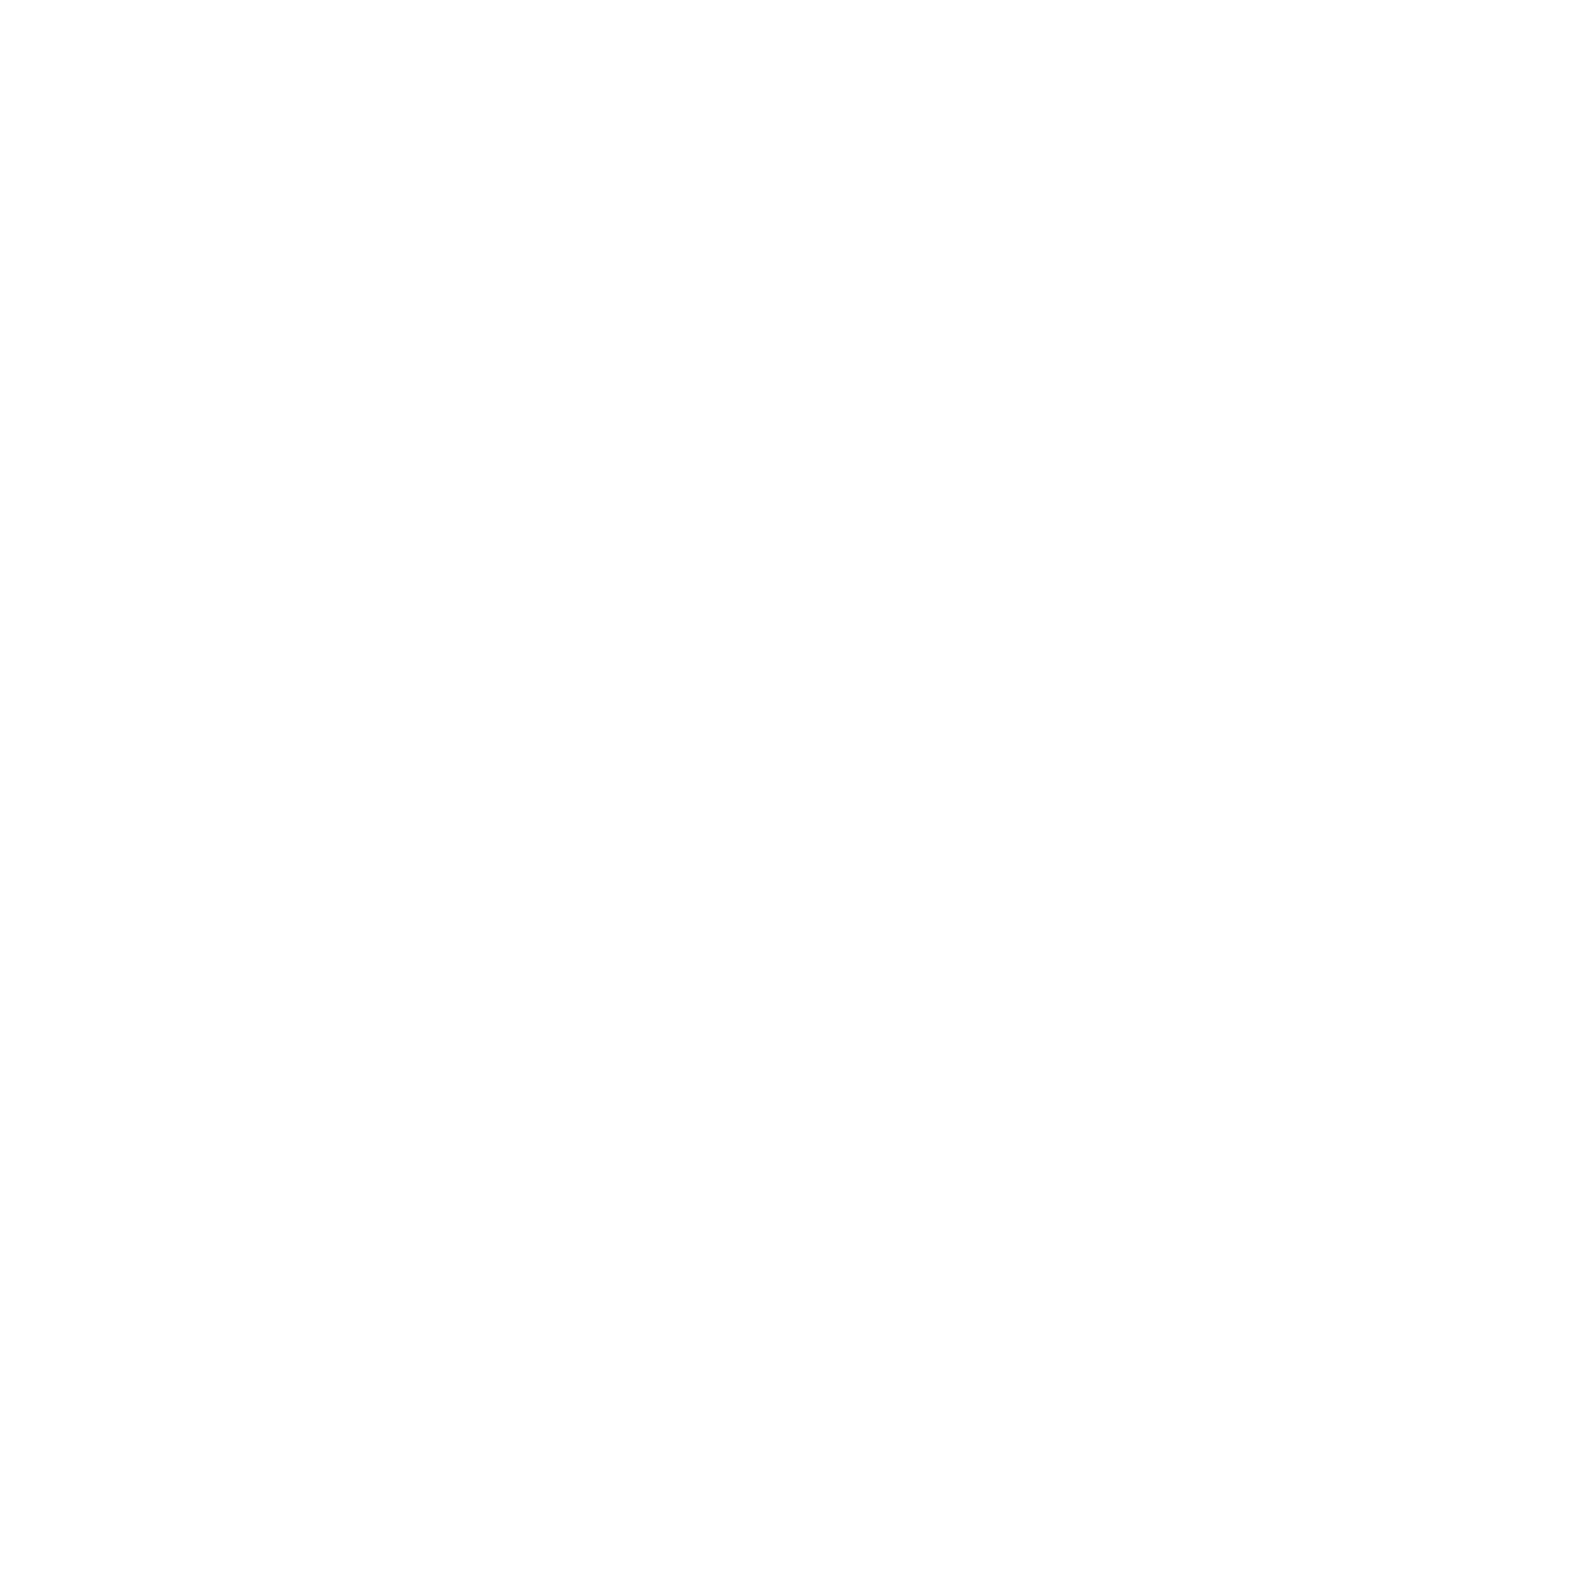

In [22]:
# size2d (kpc) vs L
fig = plt.figure(figsize=[10,10])
x = 2.5*c["size2d"] 
xlabel = "size [arcsec]"
ylabel = "$flux$ [erg/s/cm^2]"
y = c["flux"]
xrange = [3.,5e1]
yrange = [4e-18,5e-16]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)

In [23]:
print("split detected pointsources: ",  sum(pp*gg) )
print("split detected halos: ",  sum(ii*gg) )
print("split detected agn: ", sum(aa*gg))
print("split detected filaments: ", sum(ff*gg))

split detected pointsources:  61


ValueError: operands could not be broadcast together with shapes (18679950,) (2872,) 

<IPython.core.display.Javascript object>


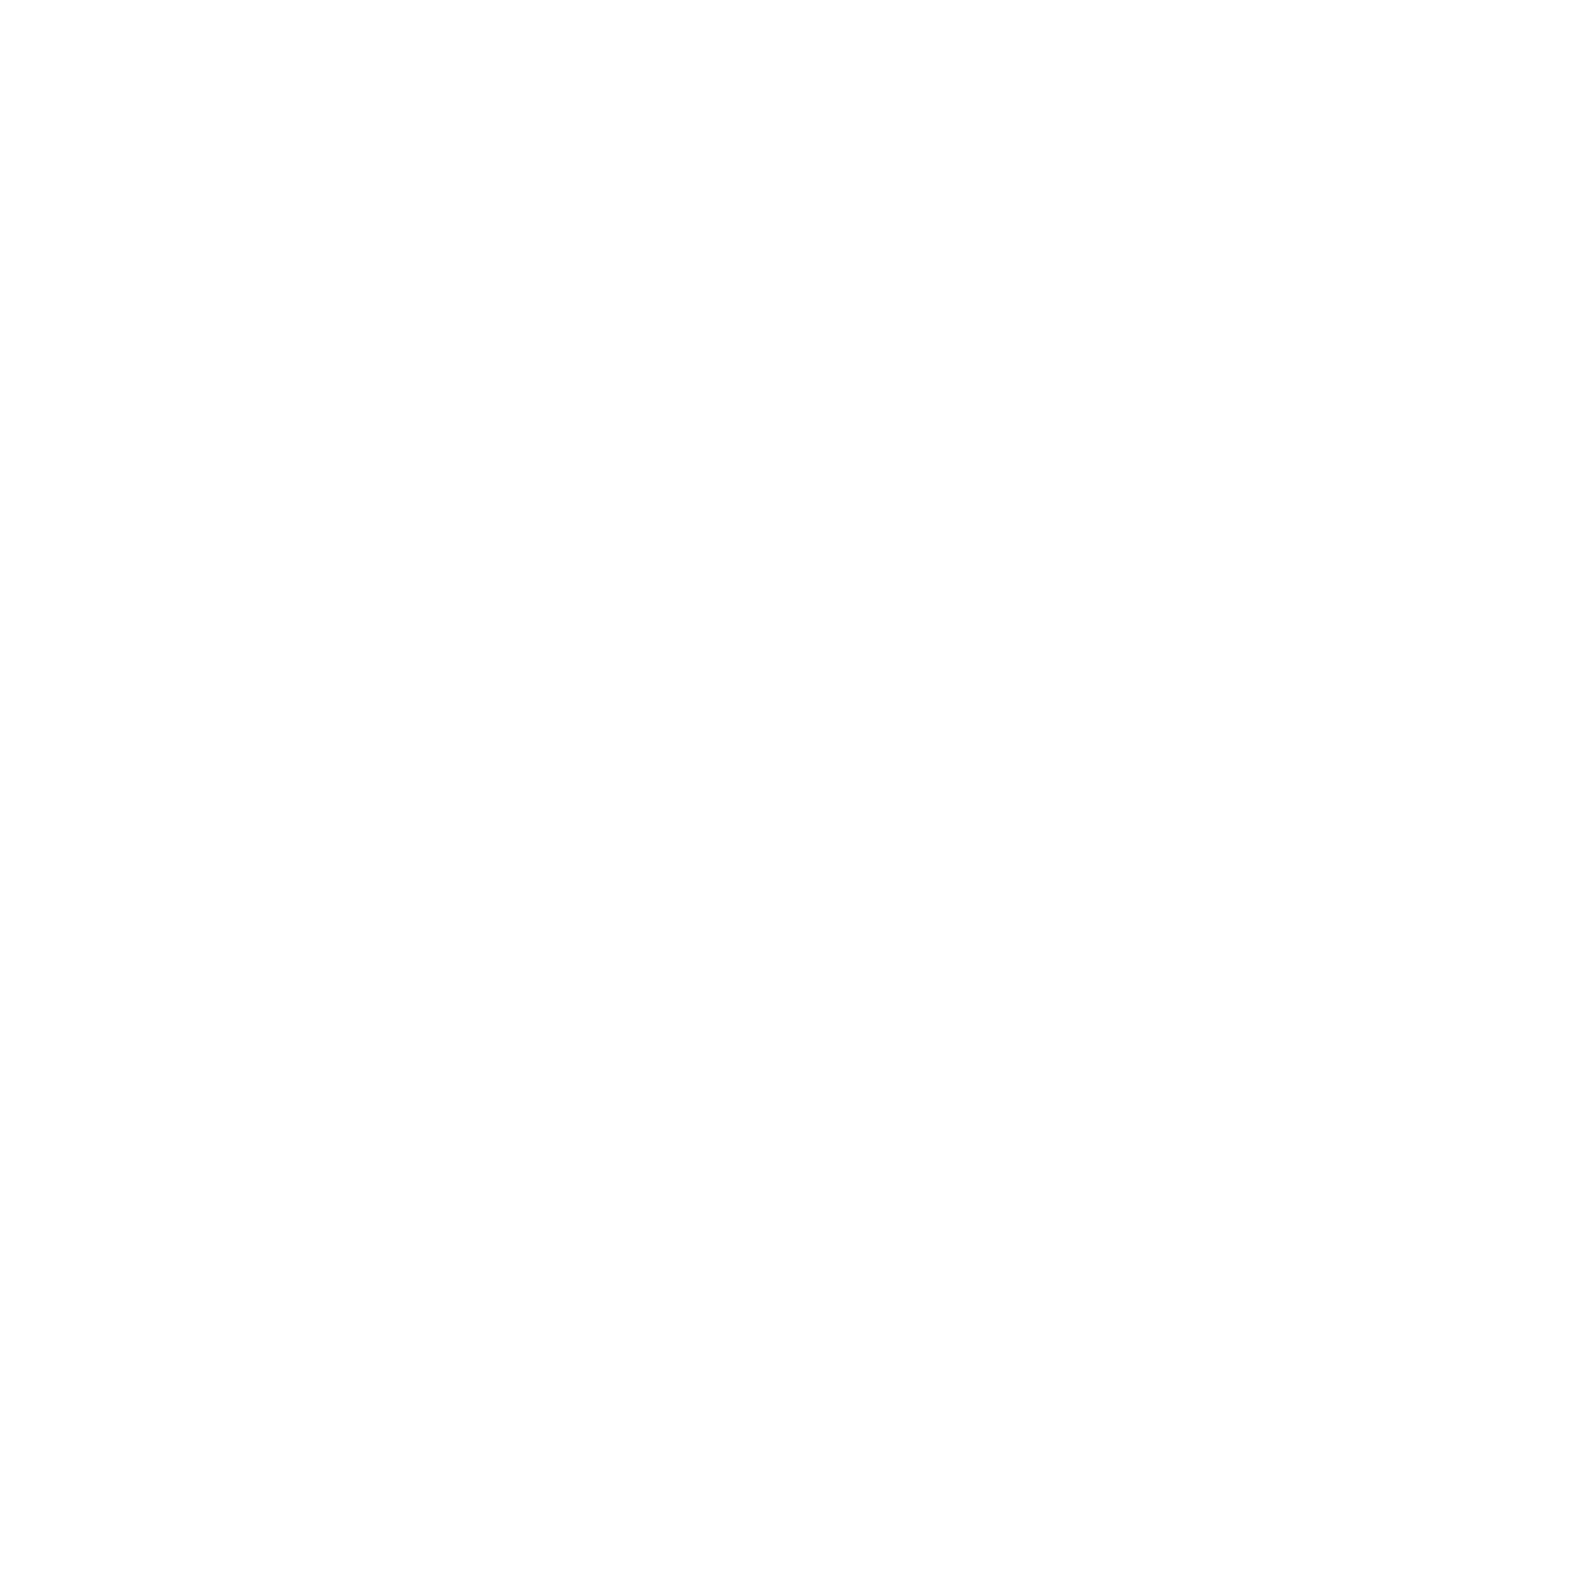

TypeError: 'Spectrum' object is not subscriptable

<IPython.core.display.Javascript object>


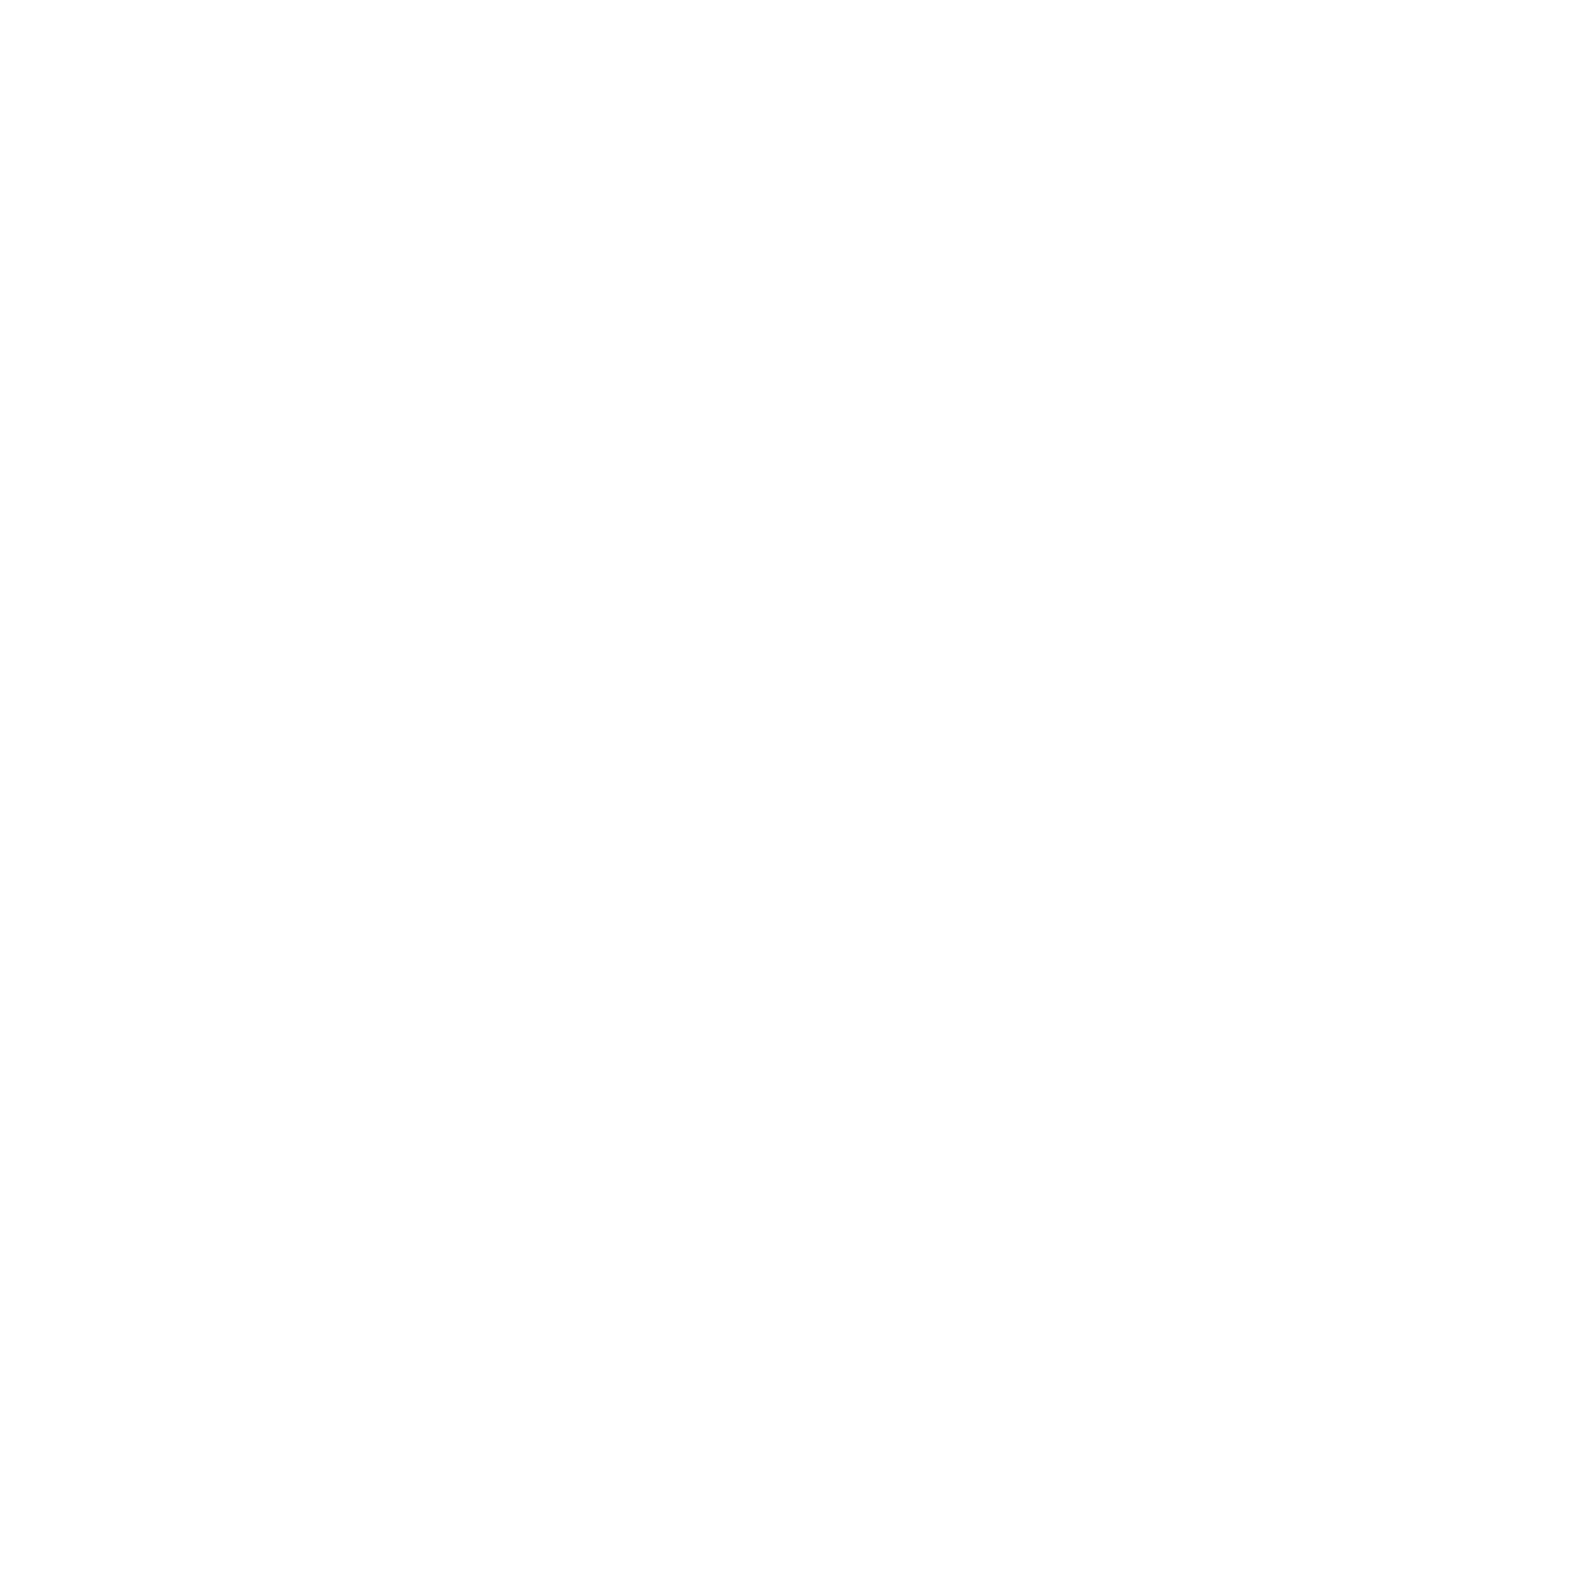

In [24]:
fig = plt.figure(figsize=[10,10])
x = 2.5*c["size2d"] * c["proper_transv_distance"]
y = c["L(if LyA)"]
ylabel = "L [erg/s]"
xlabel = "size [kpc]"
xrange = [3e1,4e2]
yrange = [3e41,4e43]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)

<IPython.core.display.Javascript object>


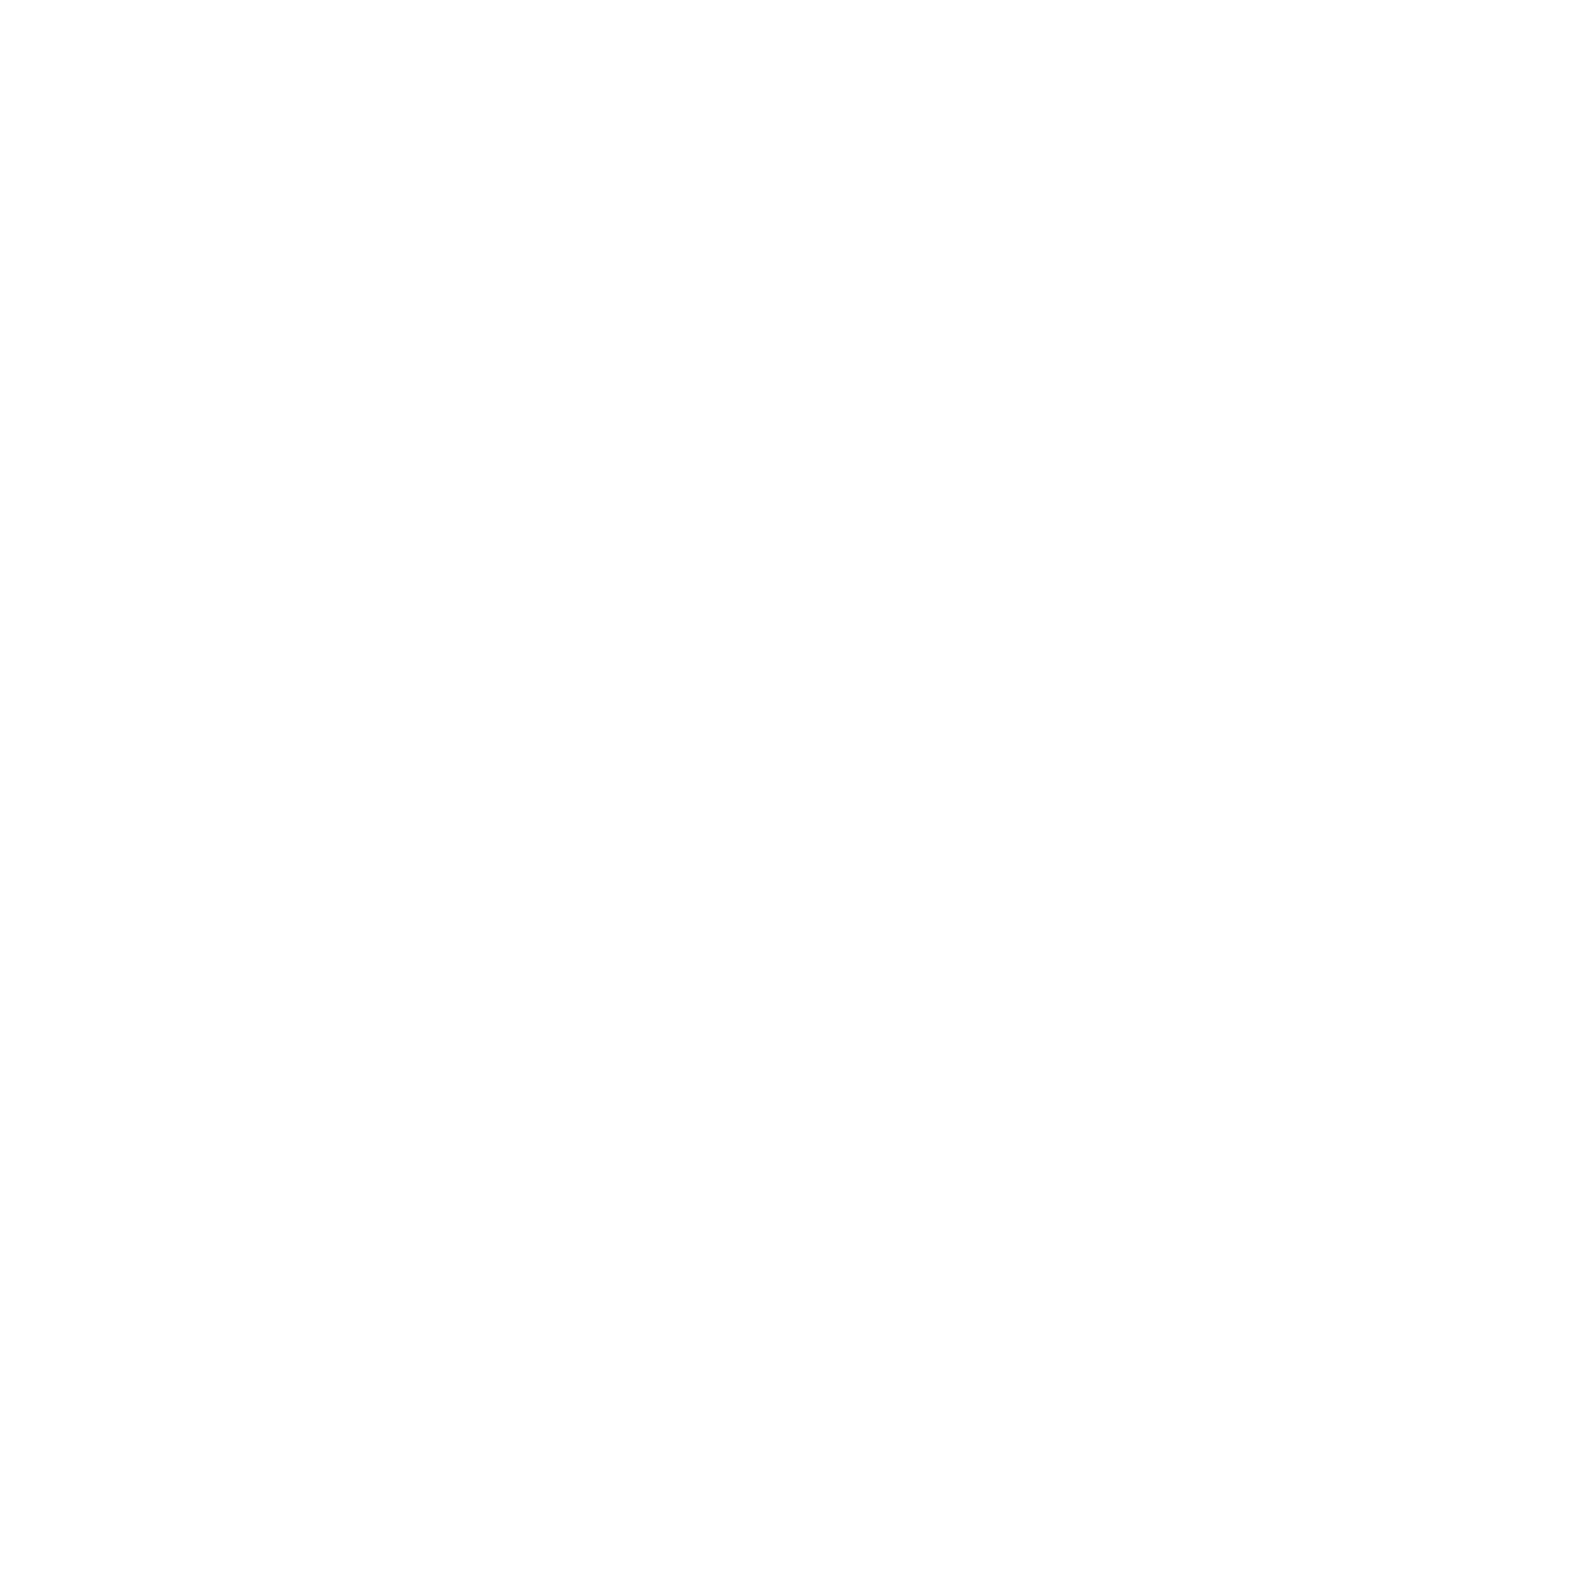

TypeError: 'Spectrum' object is not subscriptable

<IPython.core.display.Javascript object>


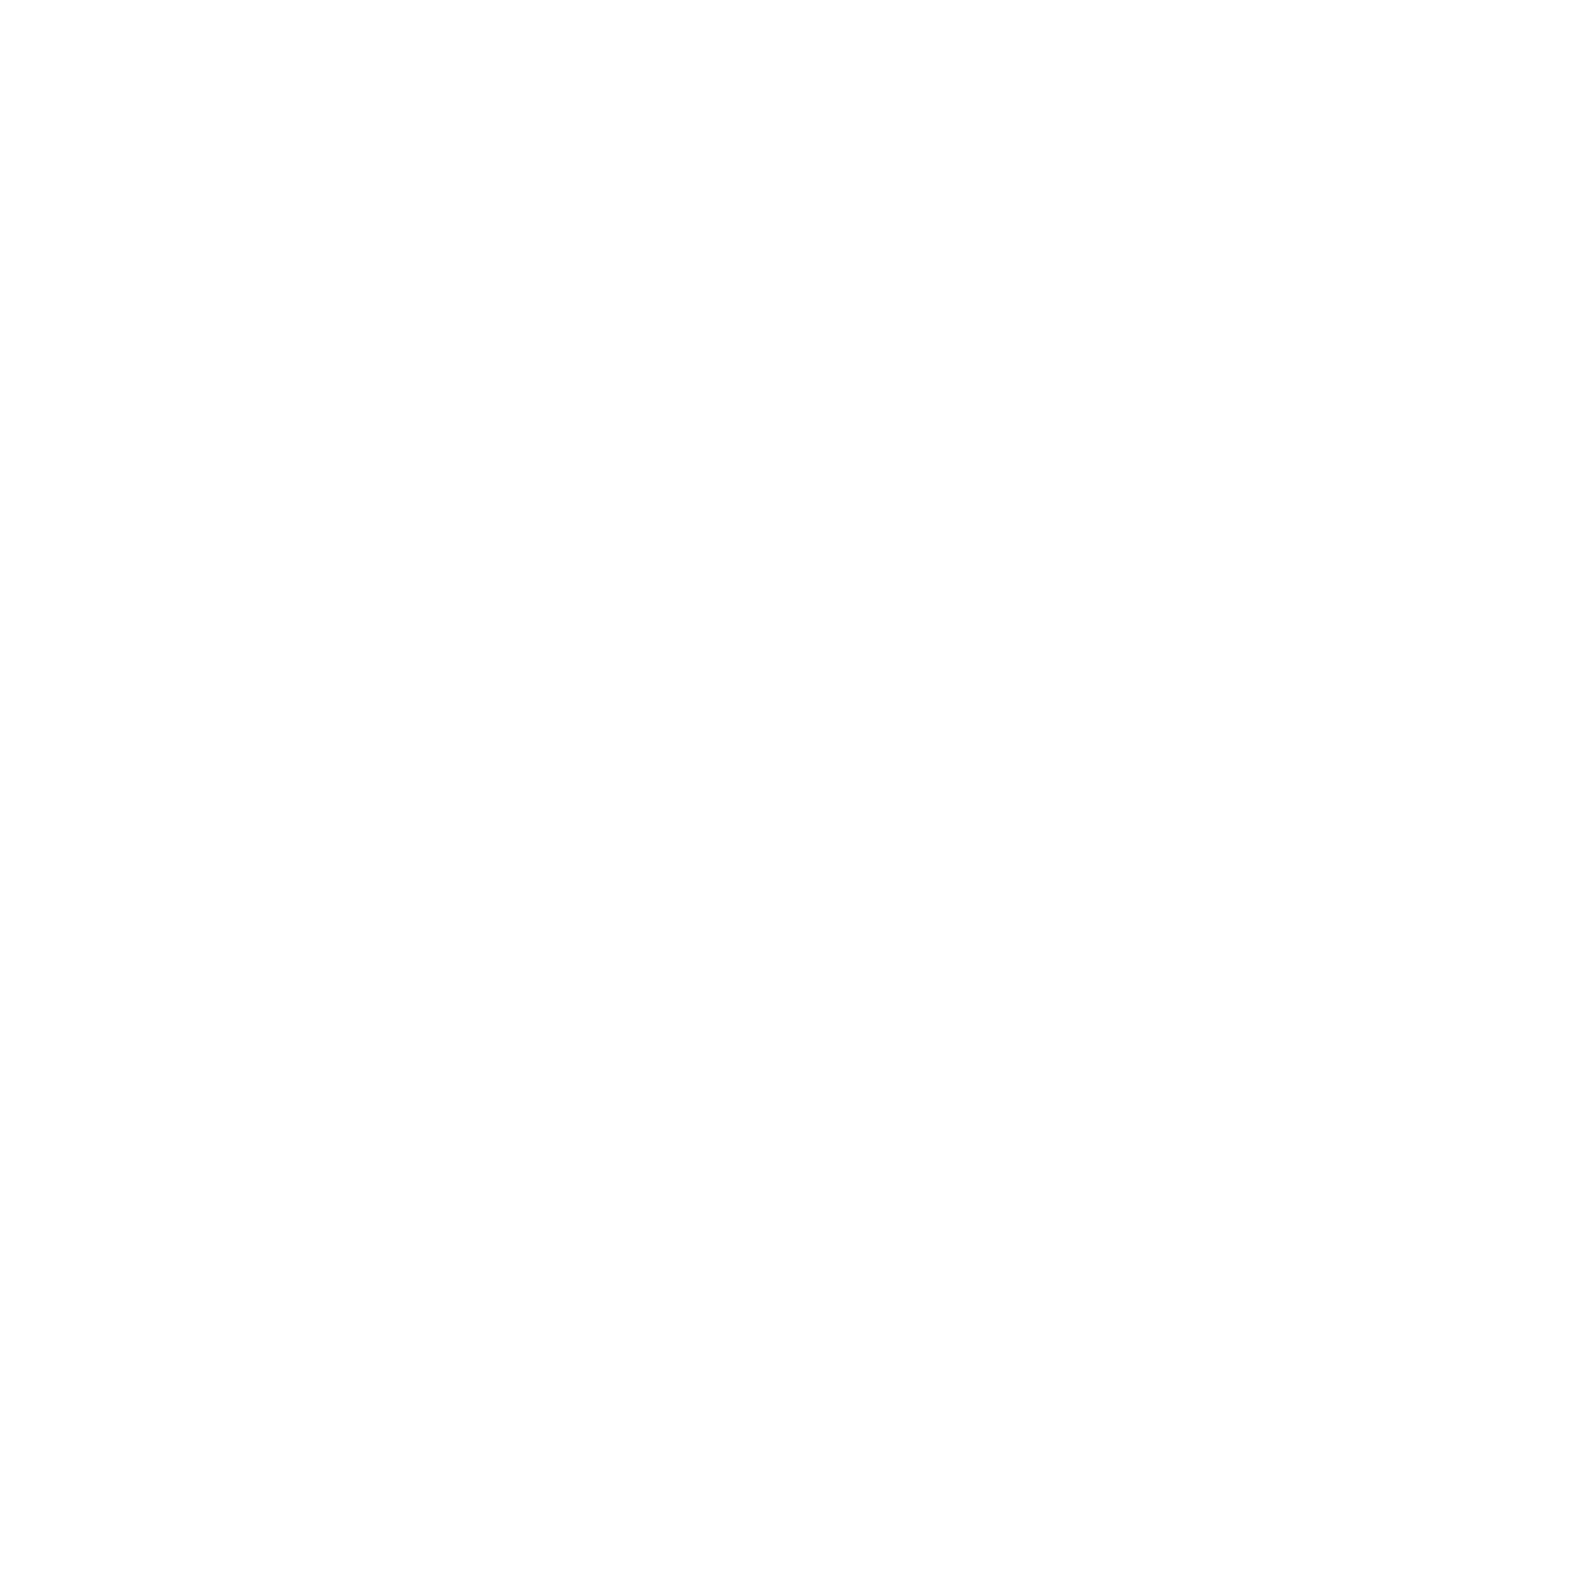

In [25]:
fig = plt.figure(figsize=[10,10])
x = 2.5*c["size2d"] * c["proper_transv_distance"]
y = c["dwl"]/c["wl_com"] * 3e5
xlabel = "size [kpc]"
ylabel = "$\sigma$ [km/s]"
xrange = [30.,3e2]
yrange = [4e2,1e4]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)


<IPython.core.display.Javascript object>


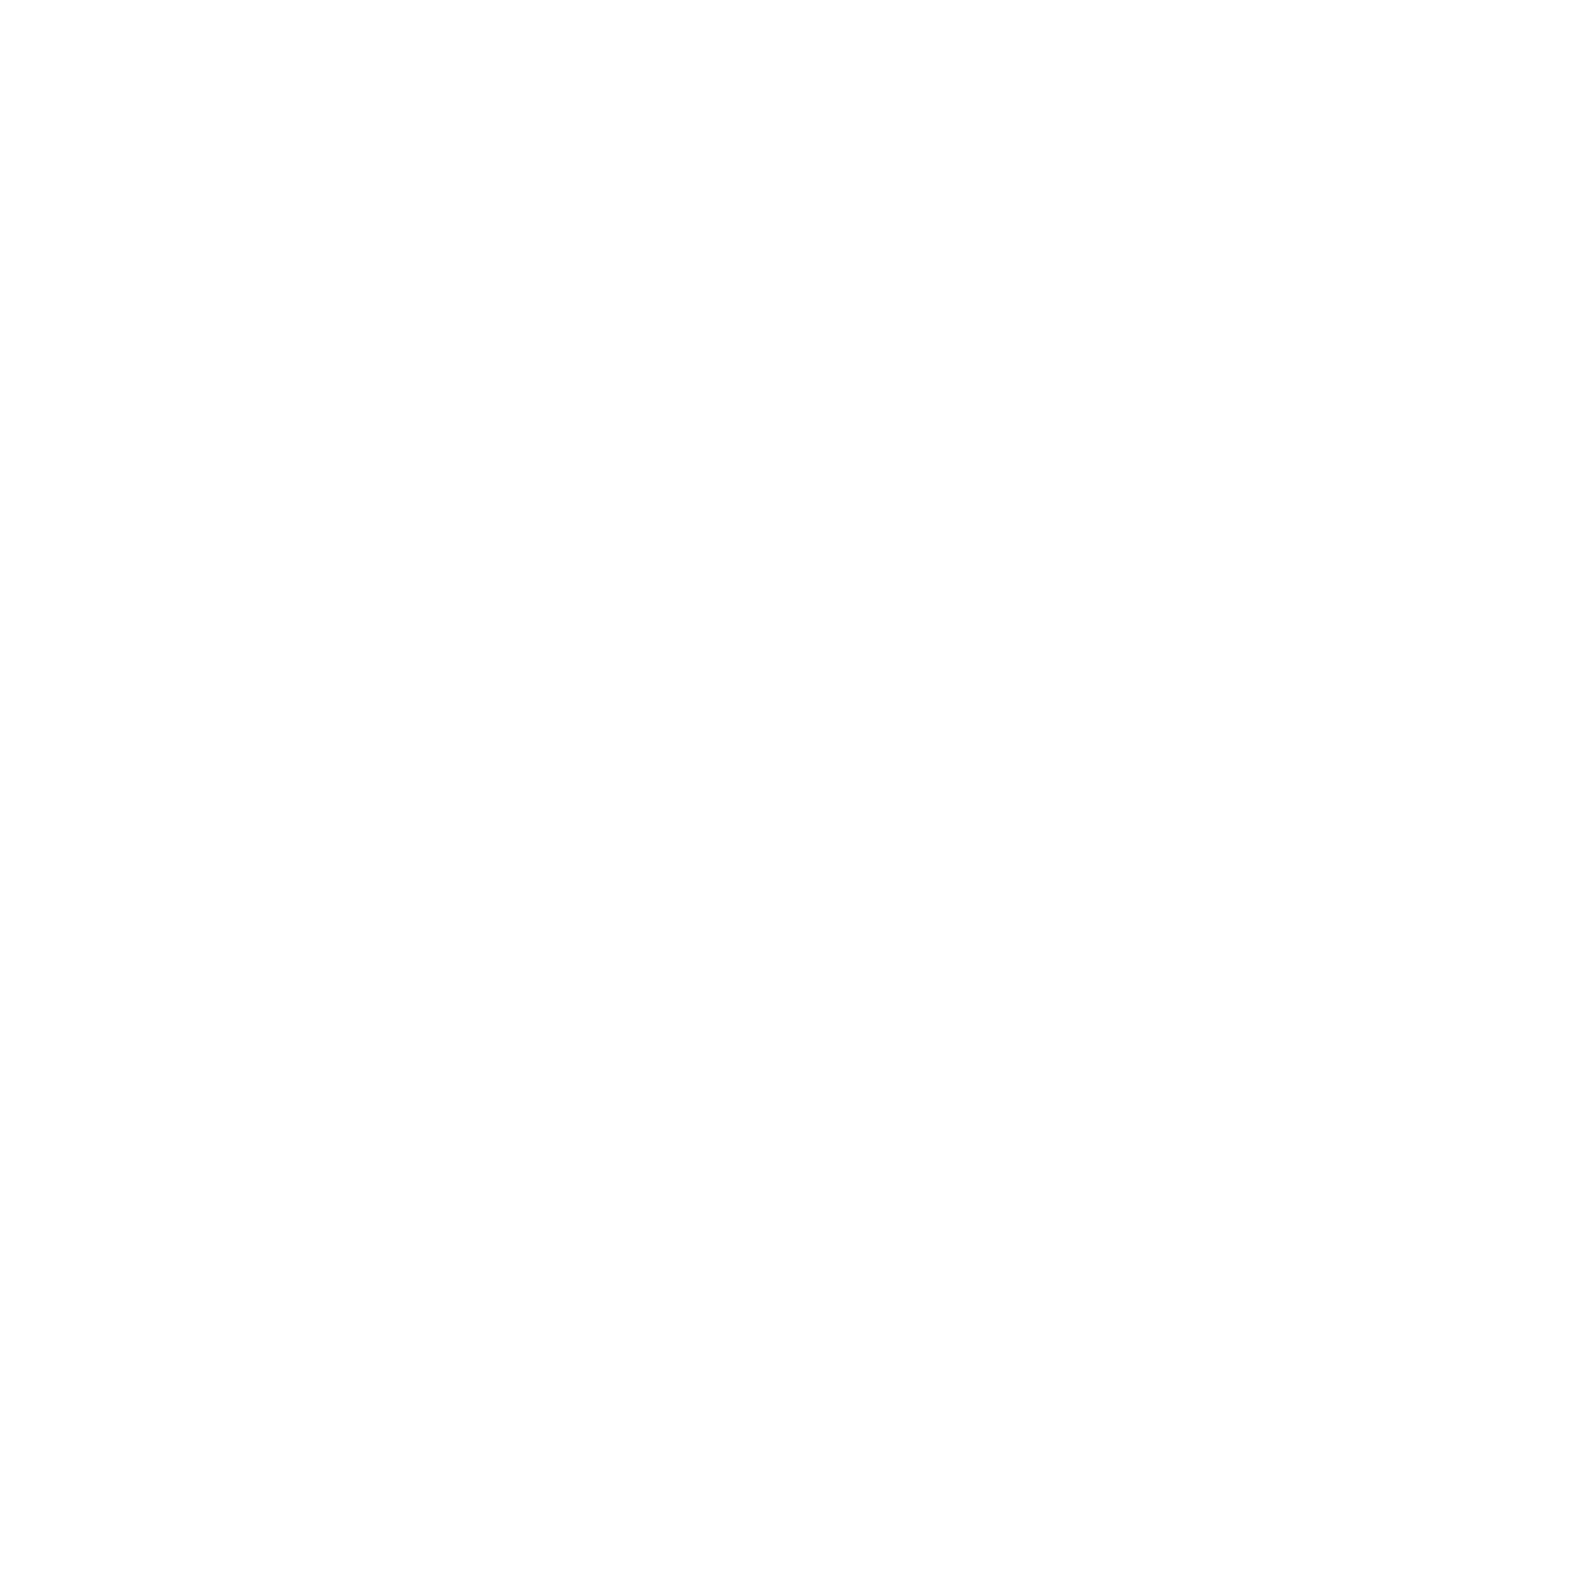

TypeError: 'Spectrum' object is not subscriptable

<IPython.core.display.Javascript object>


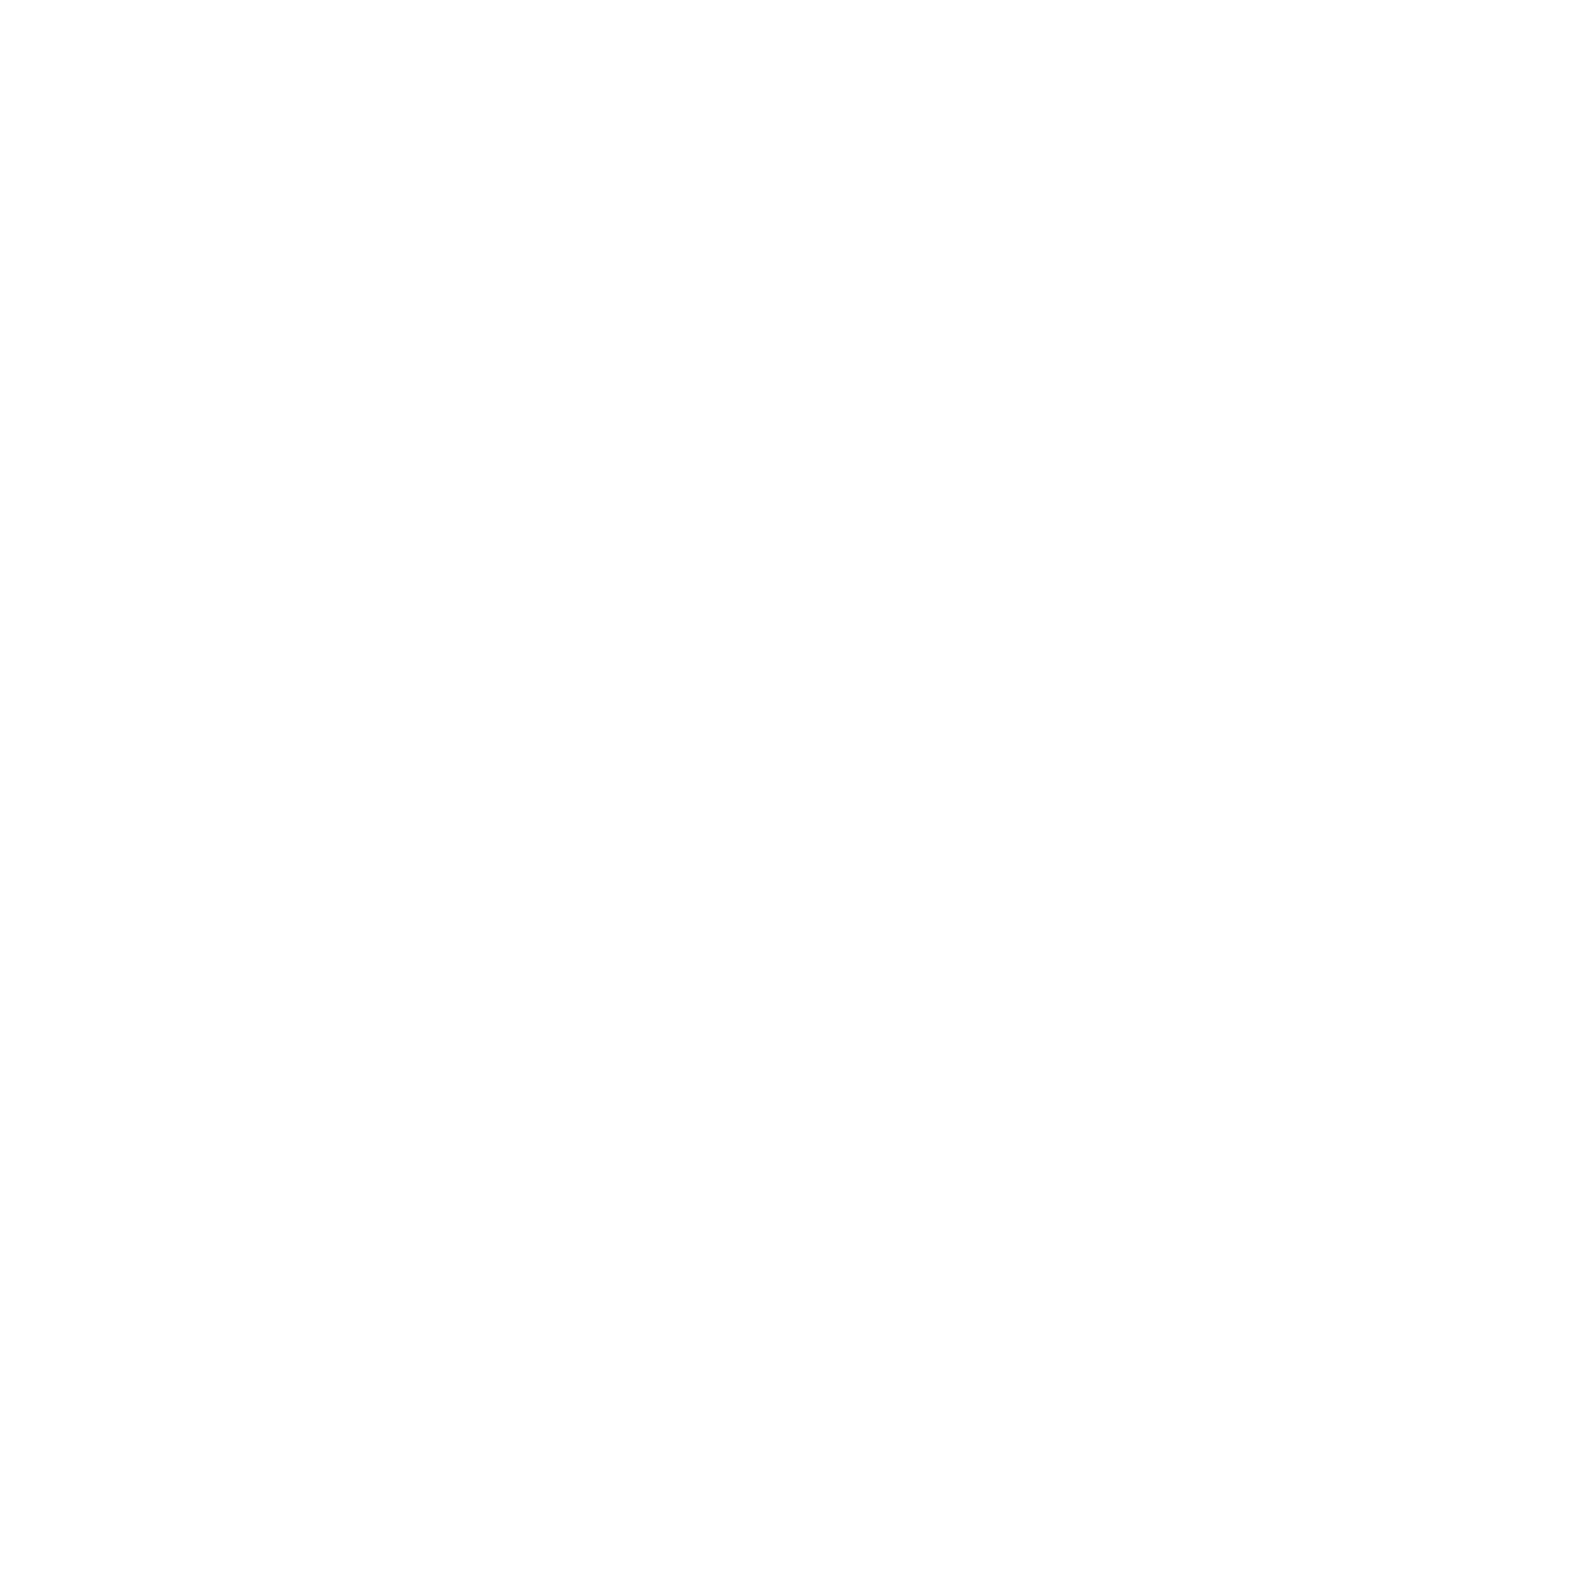

In [26]:

fig = plt.figure(figsize=[10,10])
x = c["L(if LyA)"] 
y = c["dwl"]/c["wl_com"] * 3e5
xlabel = "L [erg/s]"
ylabel = "$\sigma$ [km/s]"
xrange = [1e41,4e43]
yrange = [4e2,1e4]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)


In [ ]:
# Compute ellipticities
# Two spatial principl axes are not ordered by size, we fix this here.
b = np.array( list( map( min, zip(c["sqrt(ev1)"] , c["sqrt(ev2)"]) ) ) )
a = np.array( list( map( max, zip(c["sqrt(ev1)"] , c["sqrt(ev2)"]) ) ) )
e = 1. - b/a

In [ ]:
fig = plt.figure(figsize=[10,10])
x = c["L(if LyA)"] 
y = e
xlabel = "L [erg/s]"
ylabel = "$\epsilon = 1 - b/a$"
xrange = [3e41,4e43]
yrange = [0,0.8]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xscale("log")
plt.ylim(yrange)
plt.xlim(xrange)

In [ ]:


fig = plt.figure(figsize=[10,10])
x = c["flux"]
xrange = [4e-18,5e-16]
xlabel = "$flux$ [erg/s/cm^2]"

y = e
ylabel = "$\epsilon = 1 - b/a$"
yrange = [0,0.8]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xscale("log")
plt.ylim(yrange)
plt.xlim(xrange)

In [ ]:
matsuda2004 = ascii.read("../matsuda2004.txt")
matsuda2004

In [ ]:
if "z(if LyA)" in c.colnames:
    c.remove_column("z(if LyA)")
cpl = Column(name="z(if LyA)", \
       dtype=float,data=c["wl_com"]/1216. - 1., \
       format="%.3f", unit="", description="Redshift if LyA" )
c.add_column(cpl)

In [ ]:
ctds = cosmo.kpc_proper_per_arcmin(c["z(if LyA)"]).to(u.kpc/u.arcsec)

fig = plt.figure(figsize=[10,10])
y = c["L(if LyA)"] 
x = c["area"]*ctds**2.
ylabel = "L [erg s$^{-1}$]"
xlabel = "projected area [kpc$^2$]"
yrange = [2e41,2e44]
xrange = [200,2e5]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

scale = (2.5)**2

matsuda2004 = ascii.read("../matsuda2004.txt")

ctds_m2004 = cosmo.kpc_proper_per_arcmin(3.1).to(u.kpc/u.arcsec)
#plt.plot([0],[0],'ks', label="Matsuda+ 2004")
plt.plot(matsuda2004["size"]*scale*(ctds_m2004)**2.,matsuda2004["L"],'ks', label="Matsuda+ 2004")

matsuda2011 = ascii.read("../matsuda2011.txt")
ctds_m2011 = cosmo.kpc_proper_per_arcmin(3.1).to(u.kpc/u.arcsec)
plt.plot(matsuda2011["size"]*scale*(ctds_m2011)**2.,matsuda2011["L"],'ko', label="Matsuda+ 2011")
#plt.plot([0],[0],'ko', label="Matsuda+ 2011")


plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)

# Create narrow band images for the 5 brightest LABs

In [ ]:
# reverse sort by luminosity
N = 50
#toplot = c[ii*gg*c["showcase"]][ np.argsort( c[ii*gg*c["showcase"]]["L(if LyA)"] )[::-1] ][:N]

# Halos
kind="halos"
toplot = c[ (c['ifu'] == "074" ) * (c['id'] == 10019)]
toplot = c[ (c['ifu'] == "063" ) * (c['id'] == 5005)]
toplot = c[ (c['ifu'] == "073" ) * (c['id'] == 5004)]
toplot = c[ (c['ifu'] == "082" ) * (c['id'] == 5018)]
toplot = c[ (c['ifu'] == "085" ) * (c['id'] == 5004)]
toplot = c[ (c['ifu'] == "093" ) * (c['id'] == 5002)]
toplot = c[ (c['ifu'] == "096" ) * (c['id'] == 10009)]
toplot = c[ (c['ifu'] == "096" ) * (c['id'] == 10061)]


# Filaments
kind="filaments"
toplot = c[ (c['ifu'] == "052" ) * (c['id'] == 10045)]
toplot = c[ (c['ifu'] == "083" ) * (c['id'] == 10005)]
toplot = c[ (c['ifu'] == "086" ) * (c['id'] == 10007)]
toplot = c[ (c['ifu'] == "087" ) * (c['id'] == 5032)]

fig = plt.figure(figsize=[10,10])
y = c["L(if LyA)"] 
x = c["area"]*ctds**2.
ylabel = "L [erg s$^{-1}$]"
xlabel = "projected area [kpc$^2$]"
yrange = [2e41,2e44]
xrange = [200,2e5]
markersize=10

plt.plot( x[pp*gg],  y[pp*gg]   ,'g.' , label="split detected pointsources", markersize=markersize, alpha=0.5)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize, alpha=0.5)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize, alpha=0.5)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5, alpha=0.5)


toplotY = toplot["L(if LyA)"] 


toplot_ctds = cosmo.kpc_proper_per_arcmin(toplot["z(if LyA)"]).to(u.kpc/u.arcsec)

toplotX = toplot["area"]*toplot_ctds**2.
plt.plot( toplotX,  toplotY, 'ro',          label="split detected filaments", markersize=markersize*1.5)

scale = (2.5)**2

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)

In [ ]:
for obj in toplot:
    

    # Select prime example of filament for reference
    field = "COSMOSC"
    ifu = obj['ifu']
    id = obj['id']
    jj  =  c["ifu"] == ifu
    jj *=  c["id"] == id


    wlstart = obj["wl_com"] - obj["dwl"]/2.
    wlend = obj["wl_com"] + obj["dwl"]/2.
    ra,dec = obj["ra_com"], obj["dec_com"]
    vmin=0.
    vmax=2.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    fncal = "../specphot/mean_cal_{}.txt".format(field)

    f = plt.figure()
    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, ra = ra, dec = dec, sigma=1.4)
    ax = plt.gca()
    plt.xlabel("RA")
    plt.ylabel("Dec")
    
    #plt.title("{field} {ifu} {id} z = {z:.2f}".format(field=field, ifu=obj['ifu'], id=obj['id'], z=obj['z(if LyA)']))
    
    ax.text(.05,.95, "{field}\n{ifu}\n{id}\nz = {z:.2f}".format(field=field, ifu=obj['ifu'], id=obj['id'], z=obj['z(if LyA)']), transform=ax.transAxes, color='white',va='top',ha='left',size=16)
    
    plt.savefig( "../paper/figures/{kind}/{field}_{ifu}_{id}.pdf".format(kind=kind,field=field, ifu=obj['ifu'], id=obj['id']))

In [ ]:
! 




In [ ]:
# similar, but for VIRUS proposal
ctds = cosmo.kpc_proper_per_arcmin(c["z(if LyA)"]).to(u.kpc/u.arcsec)

fig = plt.figure(figsize=[10,10])
y = c["L(if LyA)"] 
x = c["area"]*ctds**2.
ylabel = "L [erg s$^{-1}$]"
xlabel = "projected area [kpc$^2$]"
yrange = [2e41,2e44]
xrange = [200,2e5]
markersize=12

#plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
#plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="point sources", markersize=markersize, color='green')
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="halos", markersize=markersize, color='red')
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="AGN", markersize=markersize, color='magenta')
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="filaments", markersize=markersize*1.5, color='blue')

scale = (2.5)**2

matsuda2004 = ascii.read("../matsuda2004.txt")

ctds_m2004 = cosmo.kpc_proper_per_arcmin(3.1).to(u.kpc/u.arcsec)
#plt.plot([0],[0],'ks', label="Matsuda+ 2004")
plt.plot(matsuda2004["size"]*scale*(ctds_m2004)**2.,matsuda2004["L"],'ks', label="Matsuda 04")

matsuda2011 = ascii.read("../matsuda2011.txt")
ctds_m2011 = cosmo.kpc_proper_per_arcmin(3.1).to(u.kpc/u.arcsec)
plt.plot(matsuda2011["size"]*scale*(ctds_m2011)**2.,matsuda2011["L"],'ko', label="Matsuda 11")
#plt.plot([0],[0],'ko', label="Matsuda+ 2011")


plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend(loc=4)
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)

In [ ]:
fig = plt.figure(figsize=[10,5])

x = c["flux"]
bins=np.linspace(0,1e-16,20)
__ = plt.hist(x[pp] ,   bins=bins, alpha=.1, label='pointsources')
__ = plt.hist(x[ii],    bins=bins, alpha=.1, label='halos')
__ = plt.hist(x[pp*gg], bins=bins, alpha=.7, label='split detected pointsources')
__ = plt.hist(x[ii*gg], bins=bins, alpha=.7, label='split detected halos')
__ = plt.hist(x[ff*gg], bins=bins, alpha=.7, label='split detected filaments')
__ = plt.hist(x[aa*gg], bins=bins, alpha=.7, label='split detected agn')
plt.axvline(x[jj], color="red")

plt.xlabel("flux")
plt.ylabel("N")
plt.legend()

In [ ]:
fig = plt.figure(figsize=[10,5])

x = e
bins=np.linspace(0,1.,20)
__ = plt.hist(x[pp] ,   bins=bins, alpha=.1, label='pointsources')
__ = plt.hist(x[ii],    bins=bins, alpha=.1, label='halos')
__ = plt.hist(x[pp*gg], bins=bins, alpha=.7, label='split detected pointsources')
__ = plt.hist(x[ii*gg], bins=bins, alpha=.7, label='split detected halos')
__ = plt.hist(x[ff*gg], bins=bins, alpha=.7, label='split detected filaments')
__ = plt.hist(x[aa*gg], bins=bins, alpha=.7, label='split detected agn')
plt.axvline(x[jj], color="red")

plt.xlabel("ell")
plt.ylabel("N")
plt.legend()

In [ ]:
fig = plt.figure(figsize=[10,5])

x = np.log10(c["L(if LyA)"])
nn = ~ np.isnan(x)

bins=np.linspace(41.4,43,20)
__ = plt.hist(x[nn * pp] ,   bins=bins, alpha=.1, label='pointsources')
__ = plt.hist(x[nn * ii],    bins=bins, alpha=.1, label='halos')
__ = plt.hist(x[nn * pp*gg], bins=bins, alpha=.7, label='split detected pointsources')
__ = plt.hist(x[nn * ii*gg], bins=bins, alpha=.7, label='split detected halos')
__ = plt.hist(x[nn * ff*gg], bins=bins, alpha=.7, label='split detected filaments')
__ = plt.hist(x[aa*gg], bins=bins, alpha=.7, label='split detected agn')
#plt.axvline( np.log10(x[jj]), color="red")

plt.xlabel("log(L) [log(erg/s)]")
plt.ylabel("N")
plt.legend()

In [ ]:
fig = plt.figure(figsize=[10,5])

x = 2.5 * c["size2d"]
nn = ~ np.isnan(x)

bins=np.linspace(0,15.,40)
__ = plt.hist(x[nn * pp] ,   bins=bins, alpha=.1, label='pointsources')
__ = plt.hist(x[nn * ii],    bins=bins, alpha=.1, label='halos')
__ = plt.hist(x[nn * pp*gg], bins=bins, alpha=.7, label='split detected pointsources')
__ = plt.hist(x[nn * ii*gg], bins=bins, alpha=.7, label='split detected halos')
__ = plt.hist(x[nn * ff*gg], bins=bins, alpha=.7, label='split detected filaments')
__ = plt.hist(x[aa*gg], bins=bins, alpha=.7, label='split detected agn')
#plt.axvline( np.log10(x[jj]), color="red")

plt.xlabel("2.5 x size2d [arcsec]")
plt.ylabel("N")
plt.legend()



In [ ]:
fig = plt.figure(figsize=[10,5])

x = 2.5*c["size2d"] * c["proper_transv_distance"]

nn = ~ np.isnan(x)

bins=np.linspace(0,200.,40)
__ = plt.hist(x[nn * pp] ,   bins=bins, alpha=.1, label='pointsources')
__ = plt.hist(x[nn * ii],    bins=bins, alpha=.1, label='halos')
__ = plt.hist(x[nn * pp*gg], bins=bins, alpha=.7, label='split detected pointsources')
__ = plt.hist(x[nn * ii*gg], bins=bins, alpha=.7, label='split detected halos')
__ = plt.hist(x[nn * ff*gg], bins=bins, alpha=.7, label='split detected filaments')
__ = plt.hist(x[aa*gg], bins=bins, alpha=.7, label='split detected agn')
#plt.axvline( np.log10(x[jj]), color="red")

plt.xlabel("2.5 x size2d [kpc]")
plt.ylabel("N")
plt.legend()



In [ ]:
fig = plt.figure(figsize=[10,5])

x = (c["dwl"]/c["wl_com"])* 3e5
nn = ~ np.isnan(x)

bins=np.linspace(0,5000.,20)
__ = plt.hist(x[nn * pp] ,   bins=bins, alpha=.1, label='pointsources')
__ = plt.hist(x[nn * ii],    bins=bins, alpha=.1, label='halos')
__ = plt.hist(x[nn * pp*gg], bins=bins, alpha=.7, label='split detected pointsources')
__ = plt.hist(x[nn * ii*gg], bins=bins, alpha=.7, label='split detected halos')
__ = plt.hist(x[nn * ff*gg], bins=bins, alpha=.7, label='split detected filaments')
__ = plt.hist(x[aa*gg], bins=bins, alpha=.7, label='split detected agn')
#plt.axvline( x[jj], color="red")

plt.xlabel("dz [km/z]")
plt.ylabel("N")
plt.legend()



In [ ]:
fig = plt.figure(figsize=[10,5])

x = e
bins=np.linspace(0,1.,20)
__ = plt.hist(x[pp] ,   bins=bins, alpha=.1, label='pointsources')
__ = plt.hist(x[ii],    bins=bins, alpha=.1, label='halos')
__ = plt.hist(x[pp*gg], bins=bins, alpha=.7, label='split detected pointsources')
__ = plt.hist(x[ii*gg], bins=bins, alpha=.7, label='split detected halos')
__ = plt.hist(x[ff*gg], bins=bins, alpha=.7, label='split detected filaments')
__ = plt.hist(x[aa*gg], bins=bins, alpha=.7, label='split detected agn')
plt.axvline(x[jj], color="red")

plt.xlabel("ell")
plt.ylabel("N")
plt.legend()

In [ ]:
def to_z(wl):
    return wl/1216. - 1.
    

In [ ]:
fig = plt.figure(figsize=[10,10])

x = to_z(c["wl_com"])
nn = ~ np.isnan(x)

bins=np.linspace(1.9,3.5,20)
__ = plt.hist(x[nn * pp] ,   bins=bins, alpha=.1, label='pointsources')
__ = plt.hist(x[nn * ii],    bins=bins, alpha=.1, label='halos')
__ = plt.hist(x[nn * pp*gg], bins=bins, alpha=.7, label='split detected pointsources')
__ = plt.hist(x[nn * ii*gg], bins=bins, alpha=.7, label='split detected halos')
__ = plt.hist(x[nn * ff*gg], bins=bins, alpha=.7, label='split detected filaments')
__ = plt.hist(x[aa*gg], bins=bins, alpha=.7, label='split detected agn')
#plt.axvline( x[jj], color="red")
#plt.yscale("log")
plt.xlabel("z")
plt.ylabel("N")
plt.legend()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,10])
ax = plt.subplot(111)




plt.title("halos")
cm = plt.cm.get_cmap('RdYlBu_r')
sc = plt.scatter(c[ii*gg]["ra_com"] , c[ii*gg]["dec_com"], marker='.', c = to_z( c[ii*gg]["wl_com"]) , cmap=cm )
plt.colorbar(sc)
plt.axis("equal")
ax.invert_xaxis()
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")




zz = to_z( c[ii*gg]["wl_com"])
zslizes = [[2.422,2.444],[2.438,2.460],[2.454,2.476]]

for zslize in zslizes:
    fig = plt.figure(figsize=[10,10])
    ax2 = plt.subplot(111)

    ll  = to_z( c[ii*gg]["wl_com"]) >= zslize[0]
    ll *= to_z( c[ii*gg]["wl_com"]) <  zslize[1]
    print(sum(ll))
    
    plt.title("halos")
    cm = plt.cm.get_cmap('RdYlBu_r')
    sc = plt.scatter(c[ii*gg]["ra_com"][ll] , c[ii*gg]["dec_com"][ll], marker='.', c = to_z( c[ii*gg]["wl_com"][ll]) , cmap=cm )
    plt.colorbar(sc)
    plt.axis("equal")
    ax.invert_xaxis()
    plt.xlabel("RA [deg]")
    plt.ylabel("Dec [deg]")    

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,10])
ax = plt.subplot(111)

plt.title("pointsources")
cm = plt.cm.get_cmap('RdYlBu_r')
sc = plt.scatter(c[pp*gg]["ra_com"] , c[pp*gg]["dec_com"], marker='.', c = to_z( c[pp*gg]["wl_com"]) , cmap=cm )
plt.colorbar(sc)
plt.axis("equal")
ax.invert_xaxis()
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,10])
ax = plt.subplot(111)

plt.title("pointsources")
cm = plt.cm.get_cmap('RdYlBu_r')
sc = plt.scatter(c[ff*gg]["ra_com"] , c[ff*gg]["dec_com"], marker='.', c = to_z( c[ff*gg]["wl_com"]) , cmap=cm )
plt.colorbar(sc)
plt.axis("equal")
ax.invert_xaxis()
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")

In [ ]:
# augment catalog with local desinsities and overdensities from Scoville+ 2013
import spectrum
from astropy.wcs import WCS
z_slice =[ 
 0.150, 0.157, 0.164, 0.170, 0.177, 0.184, 0.191, 0.198, 
 0.205, 0.212, 0.219, 0.226, 0.233, 0.240, 0.247, 0.254, 
 0.261, 0.268, 0.276, 0.283, 0.290, 0.297, 0.305, 0.312, 
 0.319, 0.327, 0.334, 0.341, 0.349, 0.356, 0.364, 0.372, 
 0.379, 0.387, 0.395, 0.403, 0.411, 0.419, 0.427, 0.435, 
 0.443, 0.451, 0.460, 0.468, 0.476, 0.485, 0.493, 0.502, 
 0.510, 0.519, 0.527, 0.536, 0.544, 0.553, 0.562, 0.570, 
 0.579, 0.588, 0.597, 0.605, 0.614, 0.623, 0.633, 0.642, 
 0.652, 0.662, 0.672, 0.683, 0.693, 0.704, 0.716, 0.727, 
 0.739, 0.751, 0.764, 0.776, 0.789, 0.801, 0.814, 0.827, 
 0.839, 0.852, 0.864, 0.876, 0.889, 0.901, 0.914, 0.927, 
 0.942, 0.956, 0.972, 0.989, 1.006, 1.025, 1.044, 1.065, 
 1.085, 1.106, 1.126, 1.146, 1.166, 1.186, 1.206, 1.228, 
 1.252, 1.279, 1.309, 1.342, 1.378, 1.416, 1.457, 1.499, 
 1.547, 1.603, 1.669, 1.745, 1.834, 1.933, 2.042, 2.167, 
 2.293, 2.409, 2.521, 2.629, 2.719, 2.816, 2.915]
z_slice = np.array(z_slice)
zz = np.arange(len(z_slice))

# build interpolator to query correct cube slize for redshift
f = interp1d(z_slice, zz)

d_hdu = fits.open("../scoville_densities/vor_density_per_mpc2.fits")
od_hdu = fits.open("../scoville_densities/vor_overdensity_per_mpc2.fits")

# cheat, it is RA--SIN in realit, does not make nuch of a difference << 1 px based on a few simple tests with ds9
# made sure that WCS for vor_density_per_mpc2 and  vor_overdensity_per_mpc2 are the same
hdu[0].header["CTYPE1"] = "RA---TAN"
hdu[0].header["CTYPE2"] = "DEC--TAN"

w = WCS(hdu[0].header)
w = w.dropaxis(2)


if not "local_density" in c.colnames:
    c.add_column( Column([np.nan]*len(c), name="local_density", dtype=float, description="Local density from Scoville+ 2013." ) )
if not "z_mean_local_density" in c.colnames:
    c.add_column( Column([np.nan]*len(c), name="z_mean_local_density", dtype=float, description="Local density from Scoville+ 2013." ) )
    

if not "local_over_density" in c.colnames:
    c.add_column( Column([np.nan]*len(c), name="local_over_density", dtype=float, description="Local over-density from Scoville+ 2013." ) )
if not "z_mean_local_over_density" in c.colnames:
    c.add_column( Column([np.nan]*len(c), name="z_mean_local_over_density", dtype=float, description="Local over-density from Scoville+ 2013." ) )

for r in c[:]:
    try:
        ra,dec,z = r["ra_com"], r["dec_com"], to_z( r["wl_com"])
        cx, cy = w.wcs_world2pix(ra,dec, 0)
        cx = int( np.round( cx  ))
        cy = int( np.round( cy  ))
        cz = int( np.round( f(z) ) )
        r["local_density"]      = d_hdu[0].data[cz,cy,cx]
        r["local_over_density"] = od_hdu[0].data[cz,cy,cx]
        
        
        
        d_hdu[0].data[cz][ d_hdu[0].data[cz] == 0 ] = np.nan
        od_hdu[0].data[cz][ od_hdu[0].data[cz] == 0 ] = np.nan
        
        
        r["z_mean_local_density"]      = np.nanmean(d_hdu[0].data[cz])
        r["z_mean_local_over_density"]      = np.nanmean(od_hdu[0].data[cz])
        
        #print(ra,dec,z , r["local_density"], r["local_over_density"])
    except:
        print("Error for ifu {} id {}".format(r["ifu"], r["id"]))
    

In [ ]:
z_slice =[ 
 0.150, 0.157, 0.164, 0.170, 0.177, 0.184, 0.191, 0.198, 
 0.205, 0.212, 0.219, 0.226, 0.233, 0.240, 0.247, 0.254, 
 0.261, 0.268, 0.276, 0.283, 0.290, 0.297, 0.305, 0.312, 
 0.319, 0.327, 0.334, 0.341, 0.349, 0.356, 0.364, 0.372, 
 0.379, 0.387, 0.395, 0.403, 0.411, 0.419, 0.427, 0.435, 
 0.443, 0.451, 0.460, 0.468, 0.476, 0.485, 0.493, 0.502, 
 0.510, 0.519, 0.527, 0.536, 0.544, 0.553, 0.562, 0.570, 
 0.579, 0.588, 0.597, 0.605, 0.614, 0.623, 0.633, 0.642, 
 0.652, 0.662, 0.672, 0.683, 0.693, 0.704, 0.716, 0.727, 
 0.739, 0.751, 0.764, 0.776, 0.789, 0.801, 0.814, 0.827, 
 0.839, 0.852, 0.864, 0.876, 0.889, 0.901, 0.914, 0.927, 
 0.942, 0.956, 0.972, 0.989, 1.006, 1.025, 1.044, 1.065, 
 1.085, 1.106, 1.126, 1.146, 1.166, 1.186, 1.206, 1.228, 
 1.252, 1.279, 1.309, 1.342, 1.378, 1.416, 1.457, 1.499, 
 1.547, 1.603, 1.669, 1.745, 1.834, 1.933, 2.042, 2.167, 
 2.293, 2.409, 2.521, 2.629, 2.719, 2.816, 2.915]
z_slice = np.array(z_slice)


In [ ]:
z_slice>=1.9

In [ ]:
np.median( np.nanmedian( od_hdu[0].data[(z_slice>=1.9)*(z_slice<=3.5),:,:], axis=1), axis=1)

In [ ]:
dd = od_hdu[0].data[(z_slice>=1.9)*(z_slice<=3.5),:,:].flatten()
qq = np.isnan(dd) 

In [ ]:
plt.hist( dd[~qq] )

In [ ]:
plt.hist?

In [ ]:
fig = plt.figure(figsize=[10,10])

x = c["local_over_density"]
nn = ~ np.isnan(x)

bins=np.linspace(0.,4.,20.)
ax1 = plt.twinx()


#__ = plt.hist(x[nn * pp] ,   bins=bins, alpha=.1, label='pointsources')
#__ = plt.hist(x[nn * ii],    bins=bins, alpha=.1, label='halos')
__ = plt.hist(x[nn * ii*gg], bins=bins, alpha=.5, label='split detected halos', color='red')
__ = plt.hist(x[nn * pp*gg], bins=bins, alpha=.5, label='split detected pointsources', color='green')
__ = plt.hist(x[nn * ff*gg], bins=bins, alpha=.5, label='split detected filaments', color='blue')
#__ = plt.hist(x[nn * aa*gg], bins=bins, alpha=.7, label='split detected agn')

ax2 = plt.twiny()
__ = ax2.hist( dd[~qq], bins=bins, zorder=1000, normed=True)

#__ = plt.hist([x[nn * pp*gg], x[nn * ii*gg], x[nn * aa*gg], x[nn * ff*gg]], bins=bins, alpha=.7, label=['split detected pointsources','split detected halos','split detected agn','split detected filaments'])

#plt.axvline( x[jj], color="red")
#plt.yscale("log")
ax2.set_xlabel(r"$\Sigma$ (Scoville et al. 2013)")
plt.ylabel("N")
plt.legend()

In [ ]:
fig = plt.figure(figsize=[10,10])

x = c["local_over_density"]
nn = ~ np.isnan(x)

bins=np.linspace(0.,4.,10.)
#__ = plt.hist(x[nn * pp] ,   bins=bins, alpha=.1, label='pointsources')
#__ = plt.hist(x[nn * ii],    bins=bins, alpha=.1, label='halos')
#__ = plt.hist(x[nn * ii*gg], bins=bins, alpha=.7, label='split detected halos')
#__ = plt.hist(x[nn * pp*gg], bins=bins, alpha=.7, label='split detected pointsources')
#__ = plt.hist(x[nn * ff*gg], bins=bins, alpha=.7, label='split detected filaments')
#__ = plt.hist(x[nn * aa*gg], bins=bins, alpha=.7, label='split detected agn')

__ = plt.hist([x[nn * pp*gg], x[nn * ii*gg], x[nn * aa*gg], x[nn * ff*gg]], bins=bins, alpha=.7, label=['split detected pointsources','split detected halos','split detected agn','split detected filaments'])

#plt.axvline( x[jj], color="red")
#plt.yscale("log")
plt.xlabel(r"$\Sigma$ [Mpc$^{-2}$]")
plt.ylabel("N")
plt.legend()

In [ ]:
int( np.round( f(2.2) ) )

In [ ]:
#kk  = c["size2d"] > 2.
#kk *= c["flux"] > .2e-15
#kk *= c["dwl"] < 50.
kk = (dd < 5) 
print("{} objects.".format(np.sum(kk)))
print("{} cross with halos.".format(np.sum(kk*ii)))

c_resorted = c.copy()
c_resorted = c_resorted[ kk * ii ].copy()
c_resorted.sort(keys="size2d")
c_resorted = c_resorted[::-1]

r = c_resorted[4]
#print(r)

wlstart = r["wl_com"] - 5.
wlend = r["wl_com"] + 5.
ifu =  r["ifu"]
ra,dec = r["ra_com"], r["dec_com"]
vmin=0.
vmax=2.

fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)

show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, ra = ra, dec = dec, sigma=0.)

In [ ]:
fig = plt.figure(figsize=[10,10])
y = c["L(if LyA)"] 
x = c["local_over_density"]
ylabel = "L [erg/s]"
xlabel = r"$\Sigma$ [Mpc$^{-2}$]"
yrange = [3e41,1.2e43]
xrange = [0,5]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)

In [ ]:
from collections import OrderedDict
cache = OrderedDict()

In [ ]:
def nb_image(ax, c, cal_interp, wlstart, wlend, vmin=0., vmax=2., sigma=1., A_pix = 0.5**2.):
    ww = c.grid()

    ii =  ww >= wlstart
    ii *= ww <= wlend
    
    #collapse slice 
    NB = np.sum(c.data[ii], axis=0)
    
    wwcentral = (ww[ii][0] + ww[ii][-1] )/2.
    wwdelta = ww[ii][-1] - ww[ii][0]

    # calibrate

    calim = NB * cal_interp(wwcentral) / A_pix

    colormap = plt.get_cmap('ds9staircase')

    calim[calim == 0.] = np.nan
    colormap.set_bad(color='grey')

    image = ax.imshow(gaussian_filter(calim, sigma)*1e18, vmin=vmin, vmax=vmax, origin='lower', interpolation='nearest', cmap=colormap)

    cbar = ax.figure.colorbar(image)
    plt.text(.67, .97, "wl$_{{cen}}$ = {:.1f} $\AA$\n$\Delta\lambda = {:.1f}\AA$"\
             .format(wwcentral, wwdelta), transform=ax.transAxes, color='white', va='top')
    cbar.set_label("10$^{-18}$ erg s$^{-1}$ arcsec$^{-2}$")
    cbar.set_ticks([0,.5,1.,1.5,2.])
    
    xcoll = np.nansum(calim,axis=0)
    ycoll = np.nansum(calim,axis=1)
    xx = np.arange(calim.shape[1])
    yy = np.arange(calim.shape[0])
    ymin = np.nanmin( yy[ycoll > 0.] ) 
    ymax = np.nanmax( yy[ycoll > 0.] ) 
    xmin = np.nanmin( xx[xcoll > 0.] ) 
    xmax = np.nanmax( xx[xcoll > 0.] ) 
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

In [ ]:
%run NB_Image.ipynb

In [ ]:
import matplotlib.pyplot as plt

params = {'legend.fontsize': '16',
          'figure.figsize': (15, 5),
         'axes.labelsize': '28',
         'axes.titlesize':'28',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20'}

plt.rcParams.update(params)

In [ ]:
# halos
qq = nn * ii*gg
qq *= 2.5*c["size2d"] > 7.
qq *= c["L(if LyA)"] > 2e42
print(sum(qq))

In [ ]:
# filaments
qq = nn * ff*gg
qq *= (2.5*c["size2d"] * c["proper_transv_distance"]) > 70.
qq *= c["L(if LyA)"] > 2e42
print(sum(qq))

In [ ]:
c[(c["ifu"] == "105") * (c["id"] == 5025)]


In [ ]:
if "projected_length" in c.colnames:
    c.remove_column("projected_length")
cpl = Column(name="projected_length", \
       dtype=float,data=.5 * np.sqrt(c["x_ext"]**2. + c["y_ext"]**2.)*c["proper_transv_distance"], \
       format="%.3f", unit=u.kpc, description="= (x_ext^2 + y_ext^2)^-1/2 [px] * pixelscale (=0.5) [\"/px] * transv_dist [kpc/\"]" )
c.add_column(cpl)

In [ ]:
 
for r in c[qq][:]:
    wlstart = r["wl_com"] - r["dwl"]/4.
    wlend = r["wl_com"] + r["dwl"]/4.
    ifu =  r["ifu"]
    ra,dec = r["ra_com"], r["dec_com"]
    vmin=0.
    vmax=3.

    fncube = "../data/outcube_{}_{}.fits.gz".format(field, ifu)
    show_nb_image(fncube, fncal, wlstart, wlend, vmin = vmin, vmax = vmax, ra = ra, dec = dec, sigma=1.2, ticks=[0.,1.,2.,3.])
    plt.title( "ifu: {}  id: {}".format(r["ifu"], r["id"]) )
    plt.xlabel("RA")
    plt.ylabel("Dec")
    

In [ ]:
fig = plt.figure(figsize=[10,10])
y = c["dwl"]/c["wl_com"] * 3e5
x = c["local_over_density"]
ylabel = "$\sigma$ [km/s]"
xlabel = r"$\Sigma$ [Mpc$^{-2}$]"
yrange = [4e2,1e4]
xrange = [0,5]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)

In [ ]:

fig = plt.figure(figsize=[10,10])
y = 2.5*c["size2d"] * c["proper_transv_distance"]
x = c["local_over_density"]
ylabel = "size [kpc]"
xlabel = r"$\Sigma$ [Mpc$^{-2}$]"
yrange = [30.,3e2]
xrange = [0,5]
markersize=10

plt.plot( x[pp],     y[pp]   ,'.' ,    label="pointsources", alpha=.1, markersize=markersize)
plt.plot( x[ii],     y[ii]   ,'.' ,    label="halos", alpha=.1, markersize=markersize)
plt.plot( x[pp*gg],  y[pp*gg]   ,'.' , label="split detected pointsources", markersize=markersize)
plt.plot( x[ii*gg],  y[ii*gg],'r.',    label="split detected halos", markersize=markersize)
plt.plot( x[aa*gg],  y[aa*gg],'ms',          label="split detected agn", markersize=markersize)
plt.plot( x[ff*gg],  y[ff*gg],'b1',          label="split detected filaments", markersize=markersize*1.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.loglog()
plt.ylim(yrange)
plt.xlim(xrange)